# Análisis de discrimante lineal


En 1936, Fisher formuló su teoría para el discriminate lineal (Lineal discriminant) el cual tiene muchas utilidades como clasificador.

Su concepto es similar al del PCA en el cual trata de realizar una reducción de similaridad, pero mientras el PCA es un aprendizaje **no supervisado** el LDA es **supervisado**. Utilizando esta información buscaremos la proyección que mejor nos permita separar las dos clases de interés.

![](img/proyeccion.png)

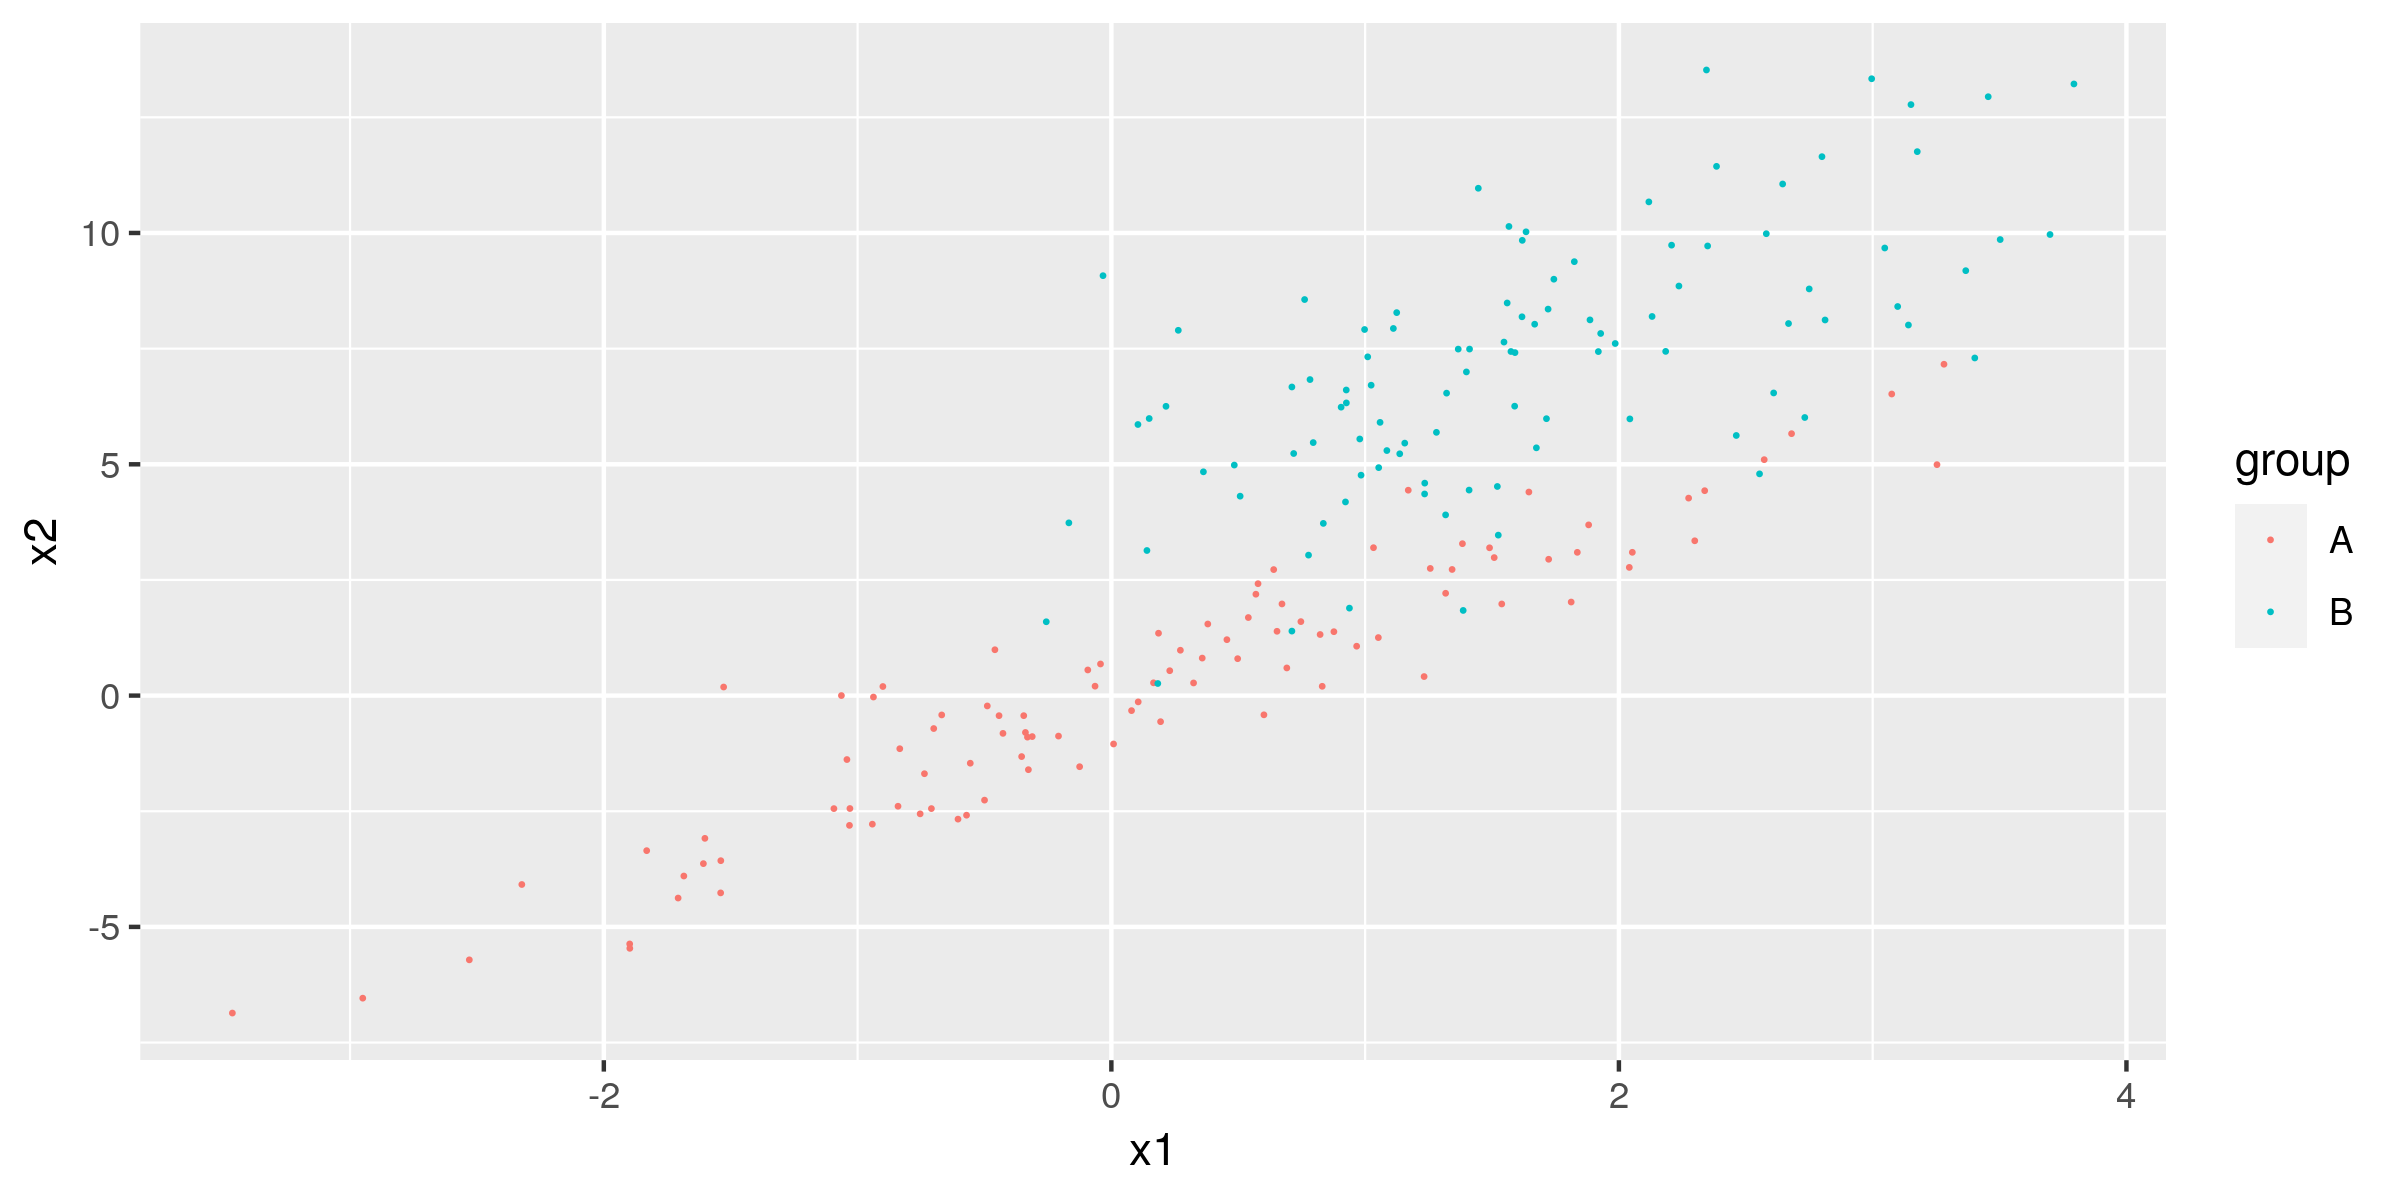

In [1]:
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)


set.seed(123)
N<-100
x1<-rnorm(N,mean=0,sd=1.5)
x2<-x1*2+rnorm(N,mean=0,sd=1)
dfa<-data.frame(group="A",x1=x1,x2=x2, stringsAsFactors = T)

x1<-rnorm(N,mean=1.5,sd=1)
x2<-x1*2+rnorm(N,mean=4,sd=2)
dfb<-data.frame(group="B",x1=x1,x2=x2, stringsAsFactors = T)

df<-data.frame(rbind(dfa,dfb))
options(repr.plot.height=4,repr.plot.width=8)
library(ggplot2)
ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)

[1] "The AUC is 0.9445"

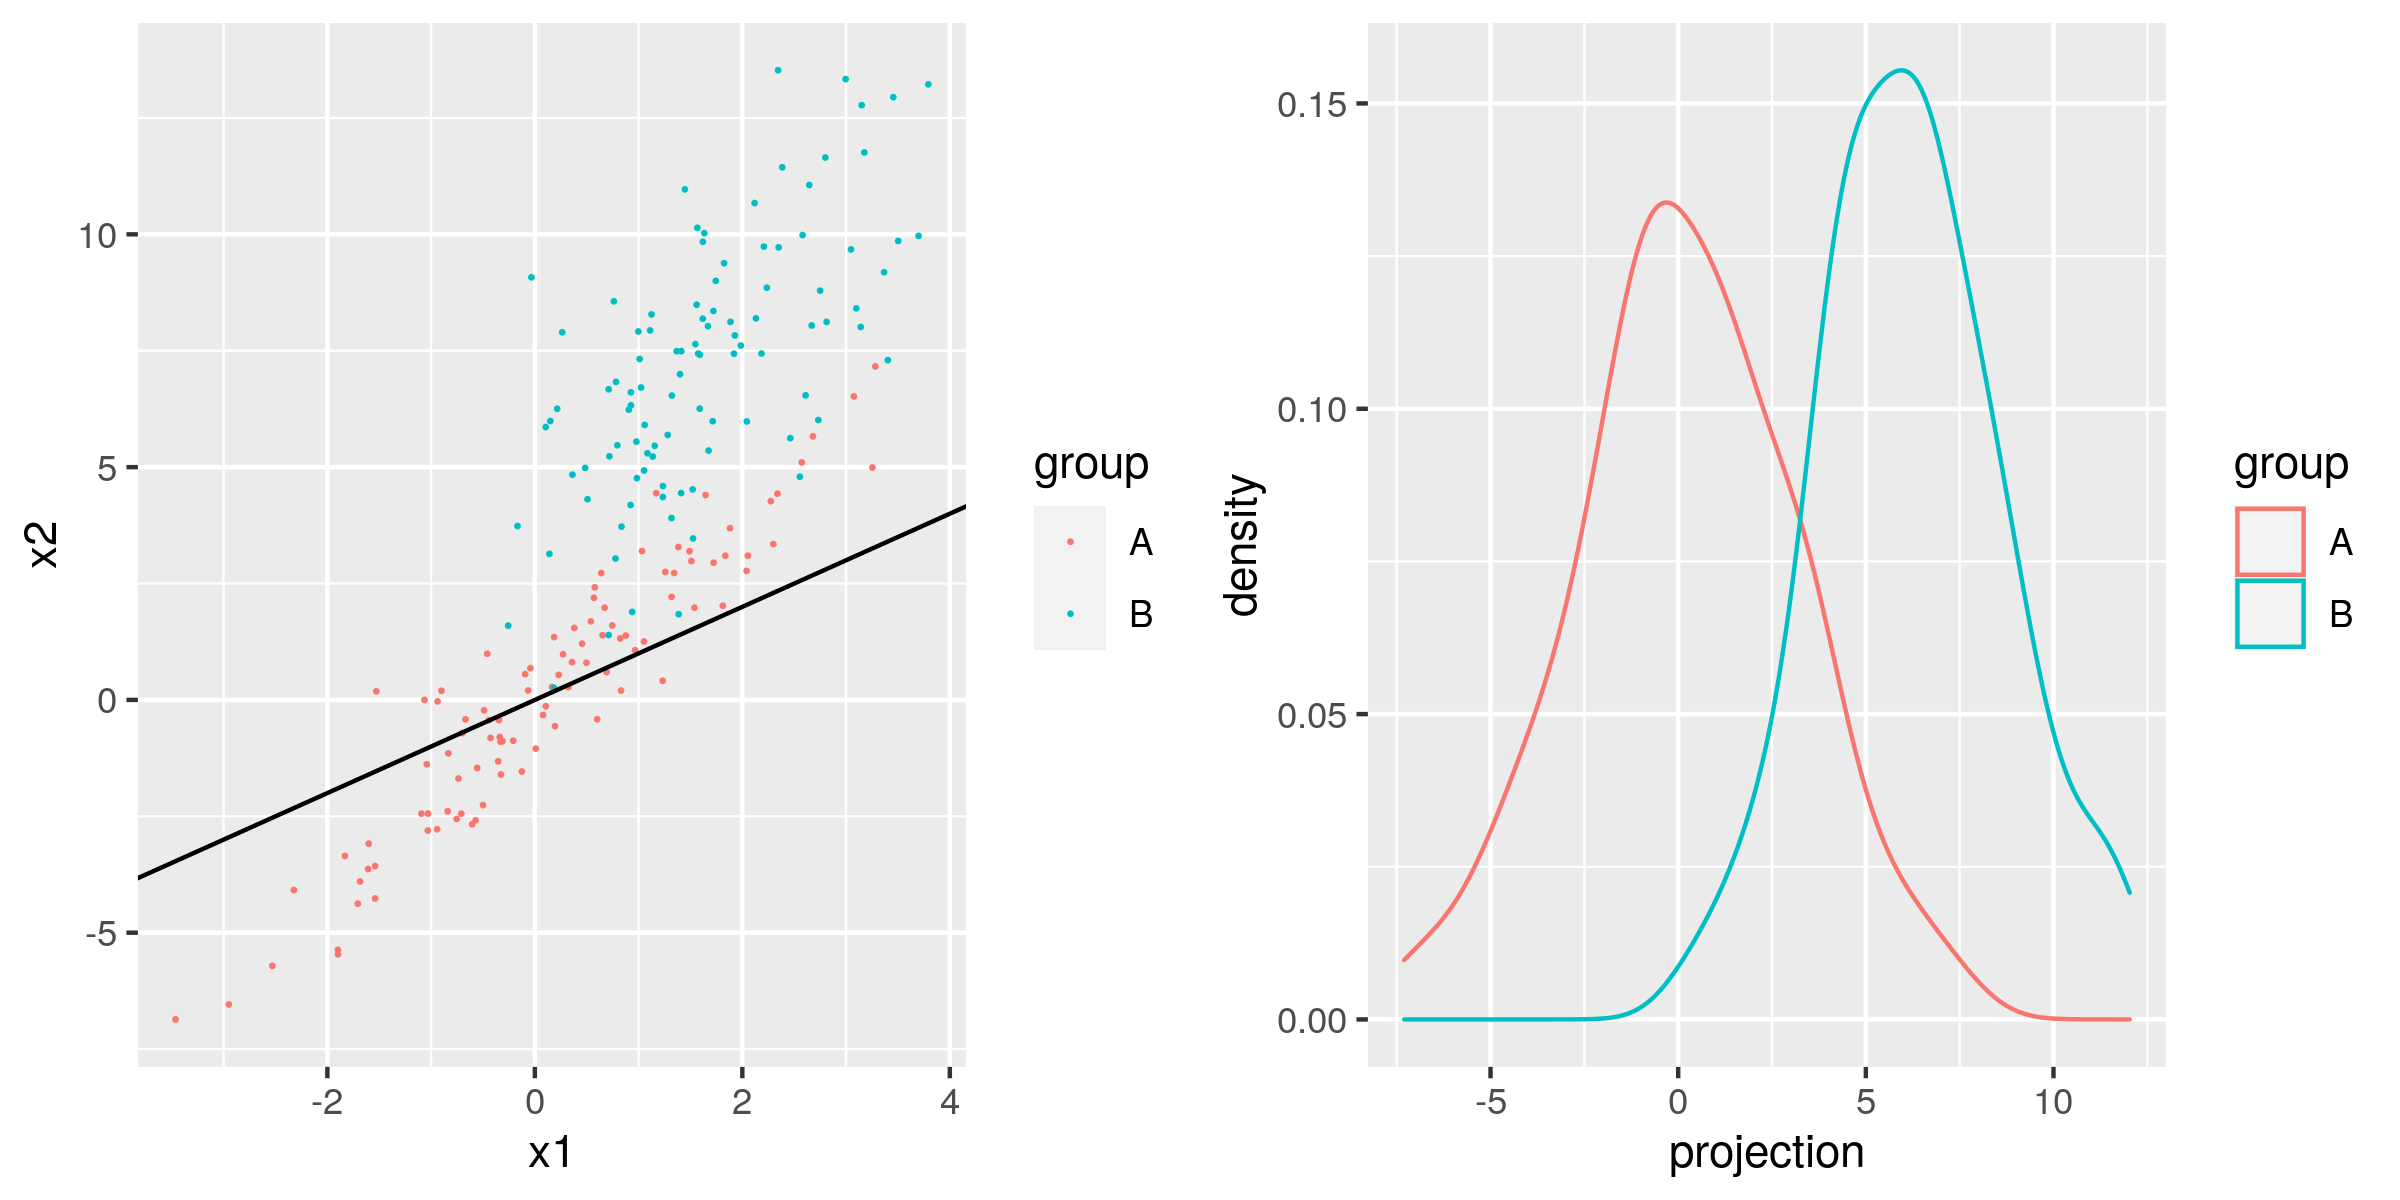

In [4]:

w<-matrix(c(1,1),nrow = 2)
w<-w/sqrt(sum(w^2))

g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()

library(ggpubr)
ggarrange(g1,g2,ncol = 2)
library(ROCR)

pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

Consideremos que tenemos dos clases y un vector sobre el que proyectaremos las dos clases, de tal forma que podamos resumir el valor de cada muestra en una sola dimensión. 
\\[
\vec y = X · \vec{w}
\\]
Donde
* X son los datos que queremos clasificar $X \in \mathbb{R}^{N\times p}$
* v es el vector de proyección, $w \in \mathbb{R}^{p\times1}$
* y son los datos proyectados, $y \in \mathbb{R}^{N\times1}$

Si, sobre el valor de $y$ definimos un umbral $th_0$ tal que si $y \geq th_0$ pertenece a una clase y si no a la otra. La elección del umbral y del vector $\vec w$ determinarán la calidad del decisor.

Una posible idea sería seleccionar un vector $w$ tal que:
\\[    
\vec w \propto (\vec m_B- \vec m_A) 
\\]
Donde:
\\[
\vec m_n=\frac{1}{N_n}\sum_{n \in C_n}{\vec{x_n}}
\\]

In [5]:
mA<-as.matrix(colMeans(subset(df,group=="A")[,c("x1","x2")]))
mB<-as.matrix(colMeans(subset(df,group=="B")[,c("x1","x2")]))
w <- mB-mA
w <- w/sum(w^2)
w

x1,0.02896025
x2,0.13662008


[1] "The AUC is 0.9602"

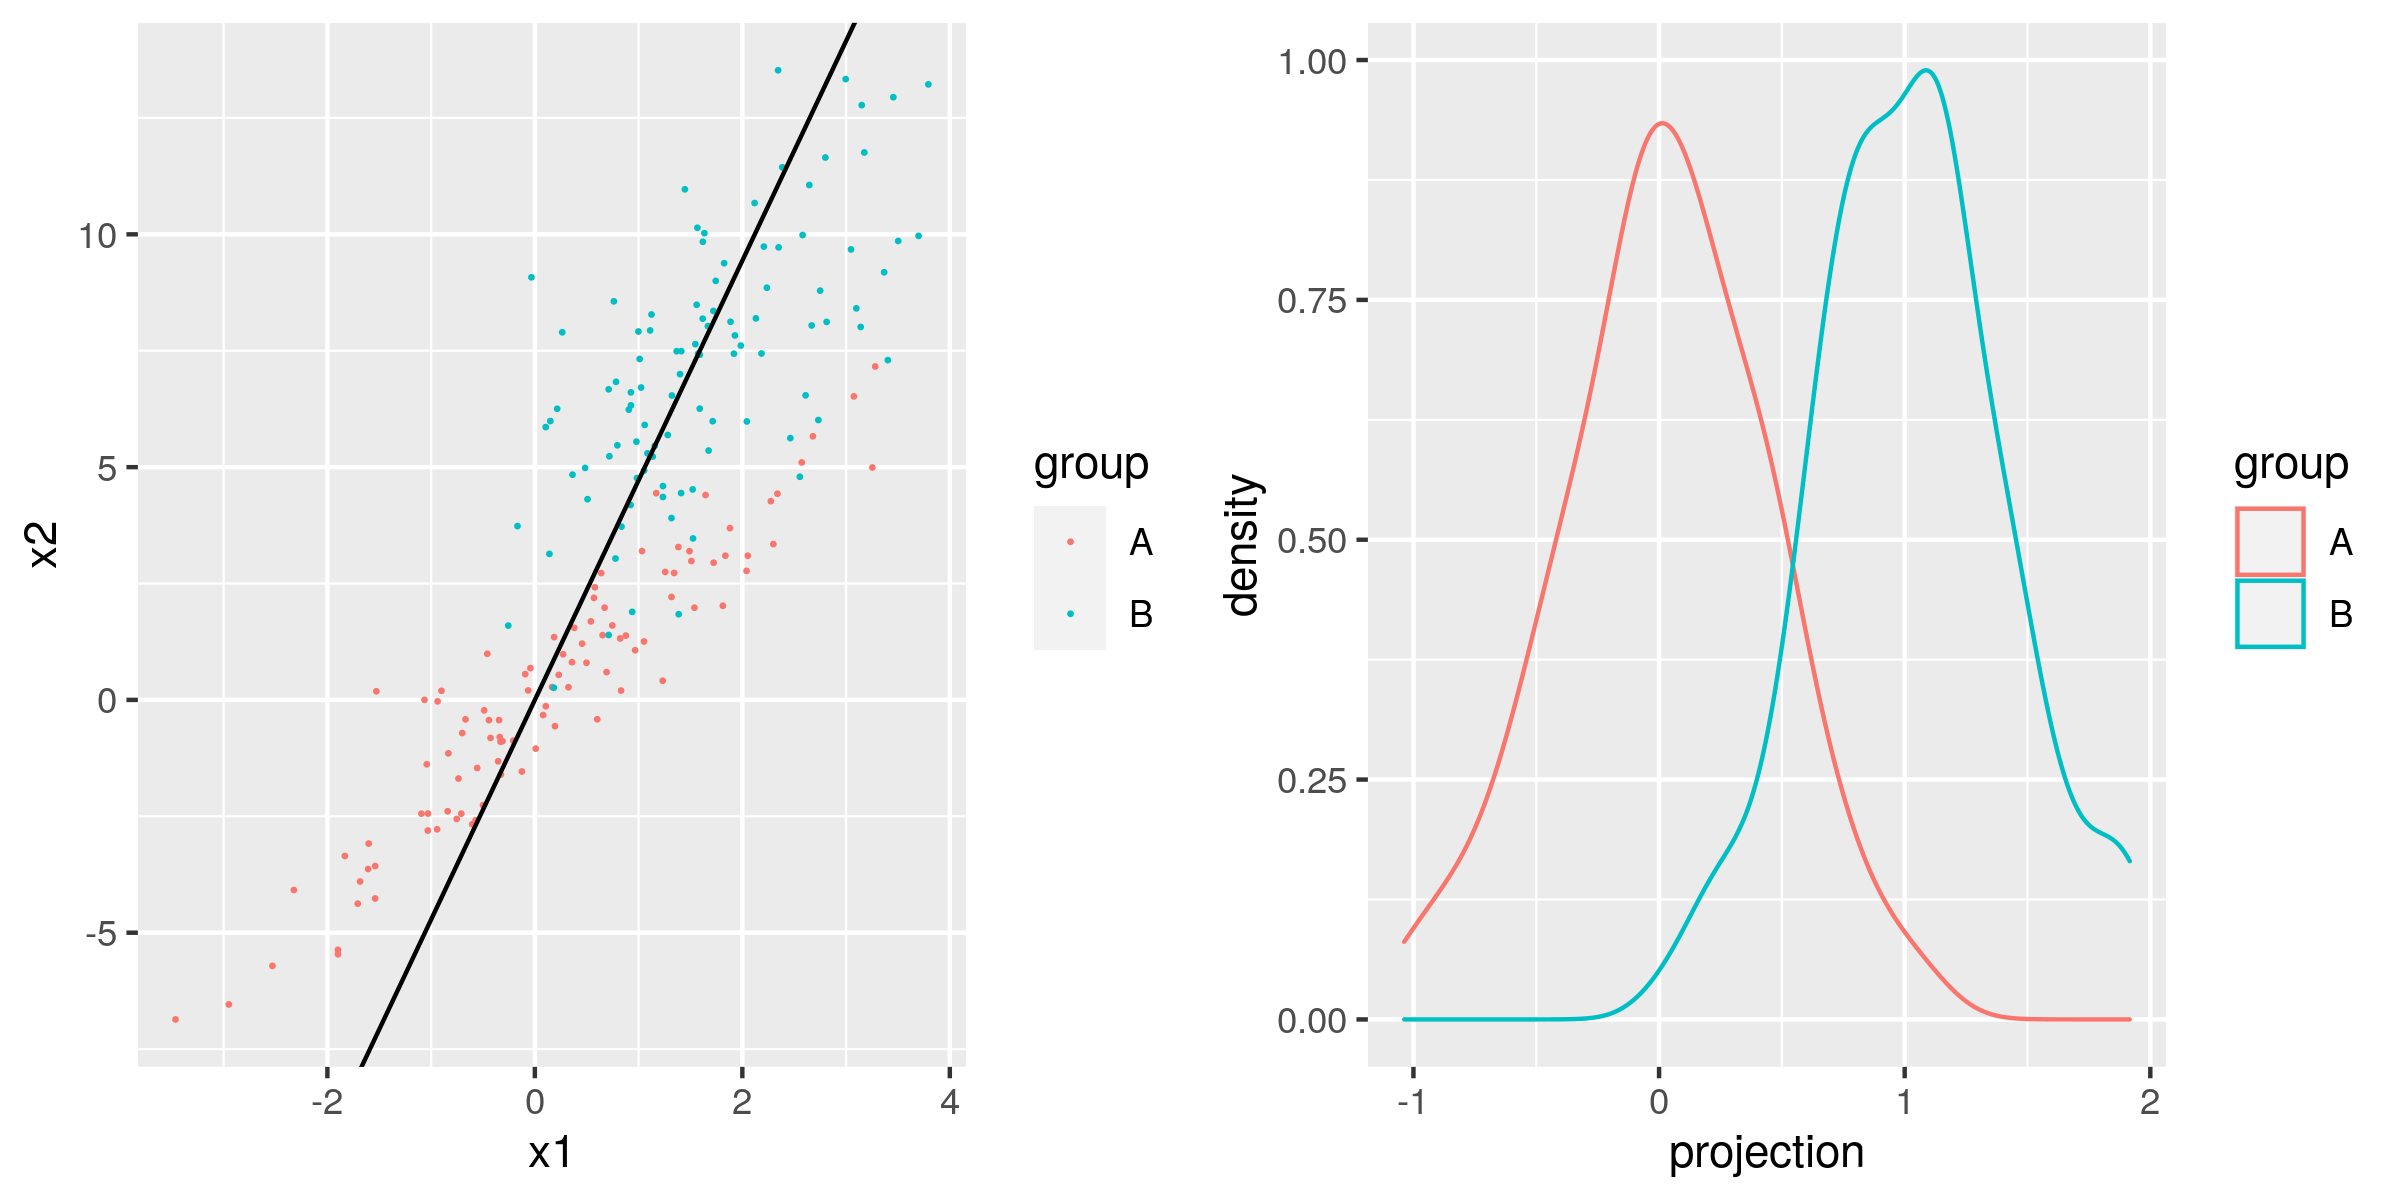

In [6]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()
ggarrange(g1,g2,ncol = 2)

pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

Esta, aunque es una solución aparentemente buena no es el óptimo. Fisher lo que busca es el máximo del cociente:
\\[
    J(w)=\frac{\sigma_{entre ~ clases}}{\sigma_{dentro ~ clases}} = \frac{m_B-m_A}{\sigma_{A proyectado}^2+\sigma_{Bproyectado}^2}=\frac{\vec w^T S_{between} \vec w}{\vec w^T S_{within} \vec w}
\\]
Donde $S_{between}$ es la varianza que hay entre clases:
\\[
S_{between} = (\vec m_B - \vec m_A)(\vec m_B - \vec m_A)^T
\\]
Recordemos la fórmula de la covarianza entre dos grupos $x$ e $y$ del módulo de estadística:
\\[
cov(X,Y) = \frac{1}{N} \sum _{i=1}^N \left( x_i-\bar{x} \right)\left( y_i-\bar{y} \right)
\\]
Donde $S_{within}$ es la suma de las varianzas de cada grupo:
\\[
S_{within} = \sum_{n \in C_A} (\vec x_n - m_A)(\vec x_n - m_A)^T + \sum_{n \in C_B} (\vec x_n - m_B)(\vec x_n - m_B)^T
\\]
El mínimo de la función $J(w)$ aparece para un $\vec w$ proporcional a:
\\[
\vec w \propto S_{within}^{-1}(\vec m_B- \vec m_A) 
\\]



In [7]:
mA<-as.matrix(colMeans(subset(df,group=="A")[,c("x1","x2")]))
mB<-as.matrix(colMeans(subset(df,group=="B")[,c("x1","x2")]))

xA<-t(as.matrix(subset(df,group=="A")[,c("x1","x2")]))
xB<-t(as.matrix(subset(df,group=="B")[,c("x1","x2")]))

In [8]:
mA_rep<-matrix(rep(mA,each=ncol(xA)), ncol=ncol(xA), byrow=TRUE)
mB_rep<-matrix(rep(mB,each=ncol(xB)), ncol=ncol(xB), byrow=TRUE)

In [9]:
Sw<-(xA-mA_rep) %*% t(xA-mA_rep)+(xB-mB_rep) %*% t(xB-mB_rep)

In [10]:
w<-solve(Sw) %*% (mB-mA)
w<-w/sqrt(sum(w^2))
w

x1,-0.7841725
x2,0.6205429


[1] "The AUC is 0.9772"

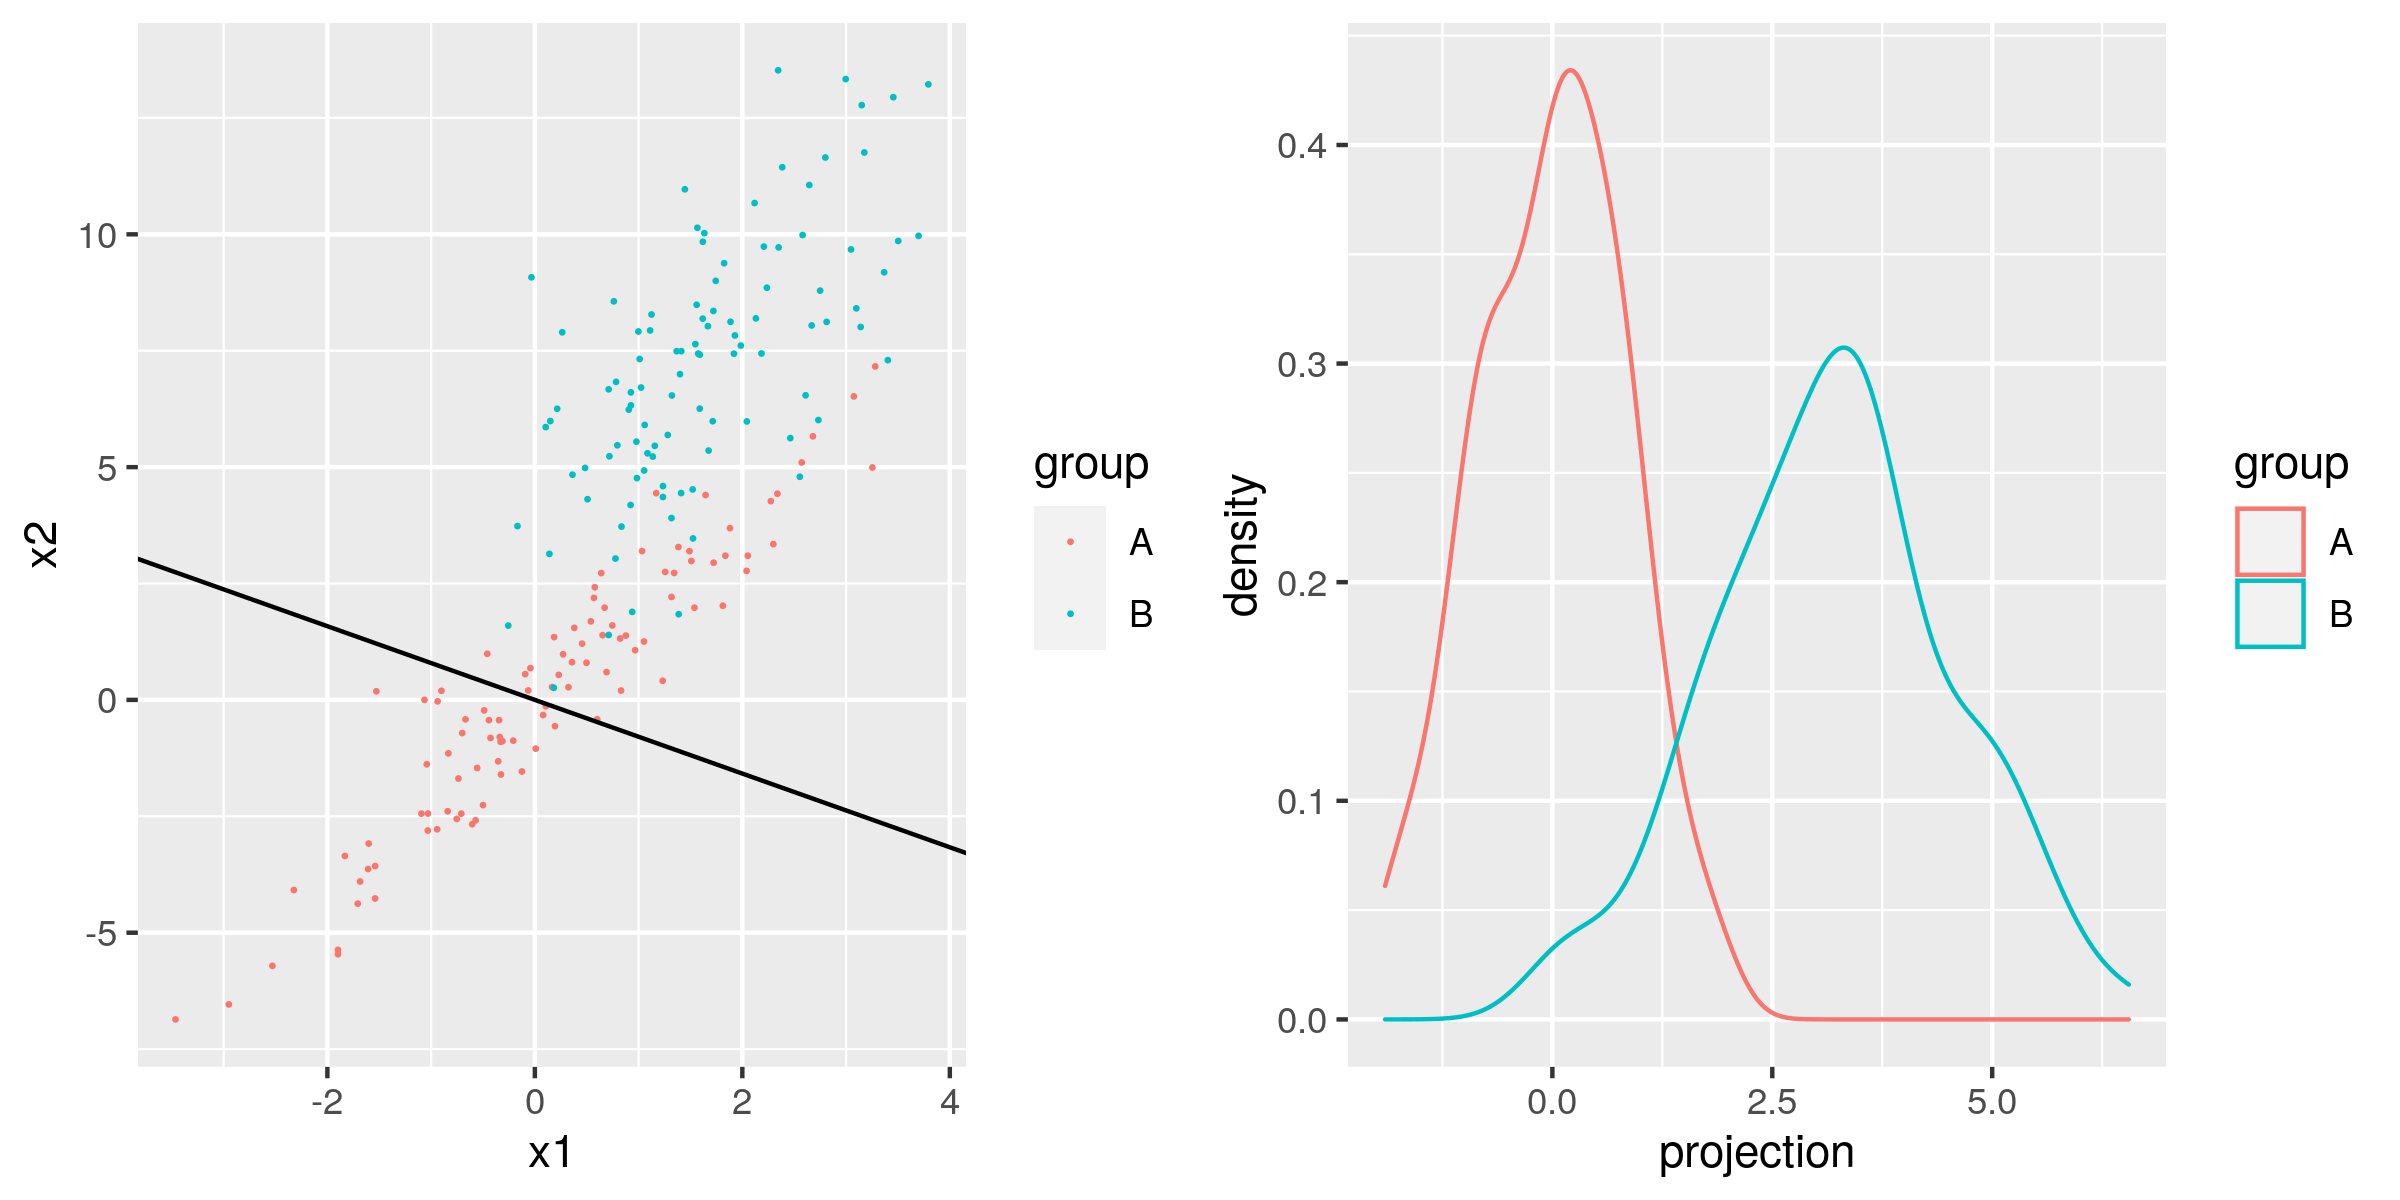

In [11]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()

ggarrange(g1,g2,ncol = 2)
pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

En R tenemos la función *lda()* del paquete MASS que nos permite hacer esto mismo de una forma más sencilla:

In [12]:
library(MASS)
l<-lda(group~x1+x2,data=df)
l

Call:
lda(group ~ x1 + x2, data = df)

Prior probabilities of groups:
  A   B 
0.5 0.5 

Group means:
         x1        x2
A 0.1356089 0.1636709
B 1.6204651 7.1684844

Coefficients of linear discriminants:
          LD1
x1 -0.6993581
x2  0.5534264

Ambos dan el mismo resultado que teníamos antes:

In [13]:
l$scaling/sqrt(sum(l$scaling^2))
w

,LD1
x1,-0.7841725
x2,0.6205429


x1,-0.7841725
x2,0.6205429


Define un umbral para clasificar la clase:

In [14]:
(mA+mB)/2
l$scaling

x1,0.878037
x2,3.666078


,LD1
x1,-0.6993581
x2,0.5534264


In [15]:
th<-c(t(l$scaling) %*% (mA+mB)/2)
th

[1] 1.414842

Podemos ver la proyección y la clase clasificada con predict:

In [ ]:
#predict(l,df)

In [ ]:
#predict(l,df)$x

El resultado de la función predict() sobre el modelo lda es equivalente a:
\\[
X · \vec w - \vec w^T ·(\vec m_B + \vec m_A)/2
\\]


In [16]:
head(data.frame(
    multiplicacion=unname(
     as.matrix(df[,2:3]) %*% l$scaling),
    multiplicacion_th=unname(
        as.matrix(df[,2:3]) %*% l$scaling-th),
    predict=unname(
        predict(l,df)$x)))

,multiplicacion,multiplicacion_th,predict
,<dbl>,<dbl>,<dbl>
1,-0.735743936,-2.1505857,-2.1505857
2,0.001472089,-1.4133697,-1.4133697
3,0.816222066,-0.5986197,-0.5986197
4,-0.149241556,-1.5640833,-1.5640833
5,-0.447624729,-1.8624665,-1.8624665
6,1.023400080,-0.3914417,-0.3914417


In [ ]:
# La media de los residuos es 0:
sum(as.matrix(df[,2:3]) %*% l$scaling-th-predict(l,df)$x)

### Comparación con regresión logística

In [17]:
model_glm<-glm(group~x1+x2,data=df,family=binomial)
model_glm
betalg<-model_glm$coefficients


Call:  glm(formula = group ~ x1 + x2, family = binomial, data = df)

Coefficients:
(Intercept)           x1           x2  
     -3.641       -2.206        1.729  

Degrees of Freedom: 199 Total (i.e. Null);  197 Residual
Null Deviance:	    277.3 
Residual Deviance: 71.62 	AIC: 77.62

Recordemos que significaban estos coeficientes:
\\[
log\left( \frac{p_A}{p_B} \right) = \beta_0+\beta_1·x_1+\beta_2·x2   
\\]

El umbral de decisión de una clase u otra lo tenemos en:
\\[
0 = \beta_0+\beta_1·x_1+\beta_2·x2 \\
\beta_2·x2= -\beta_0-\beta_1·x_1 \\
x2= -\frac{\beta_0}{\beta_2}-\frac{\beta_1}{\beta_2}x_1
\\]

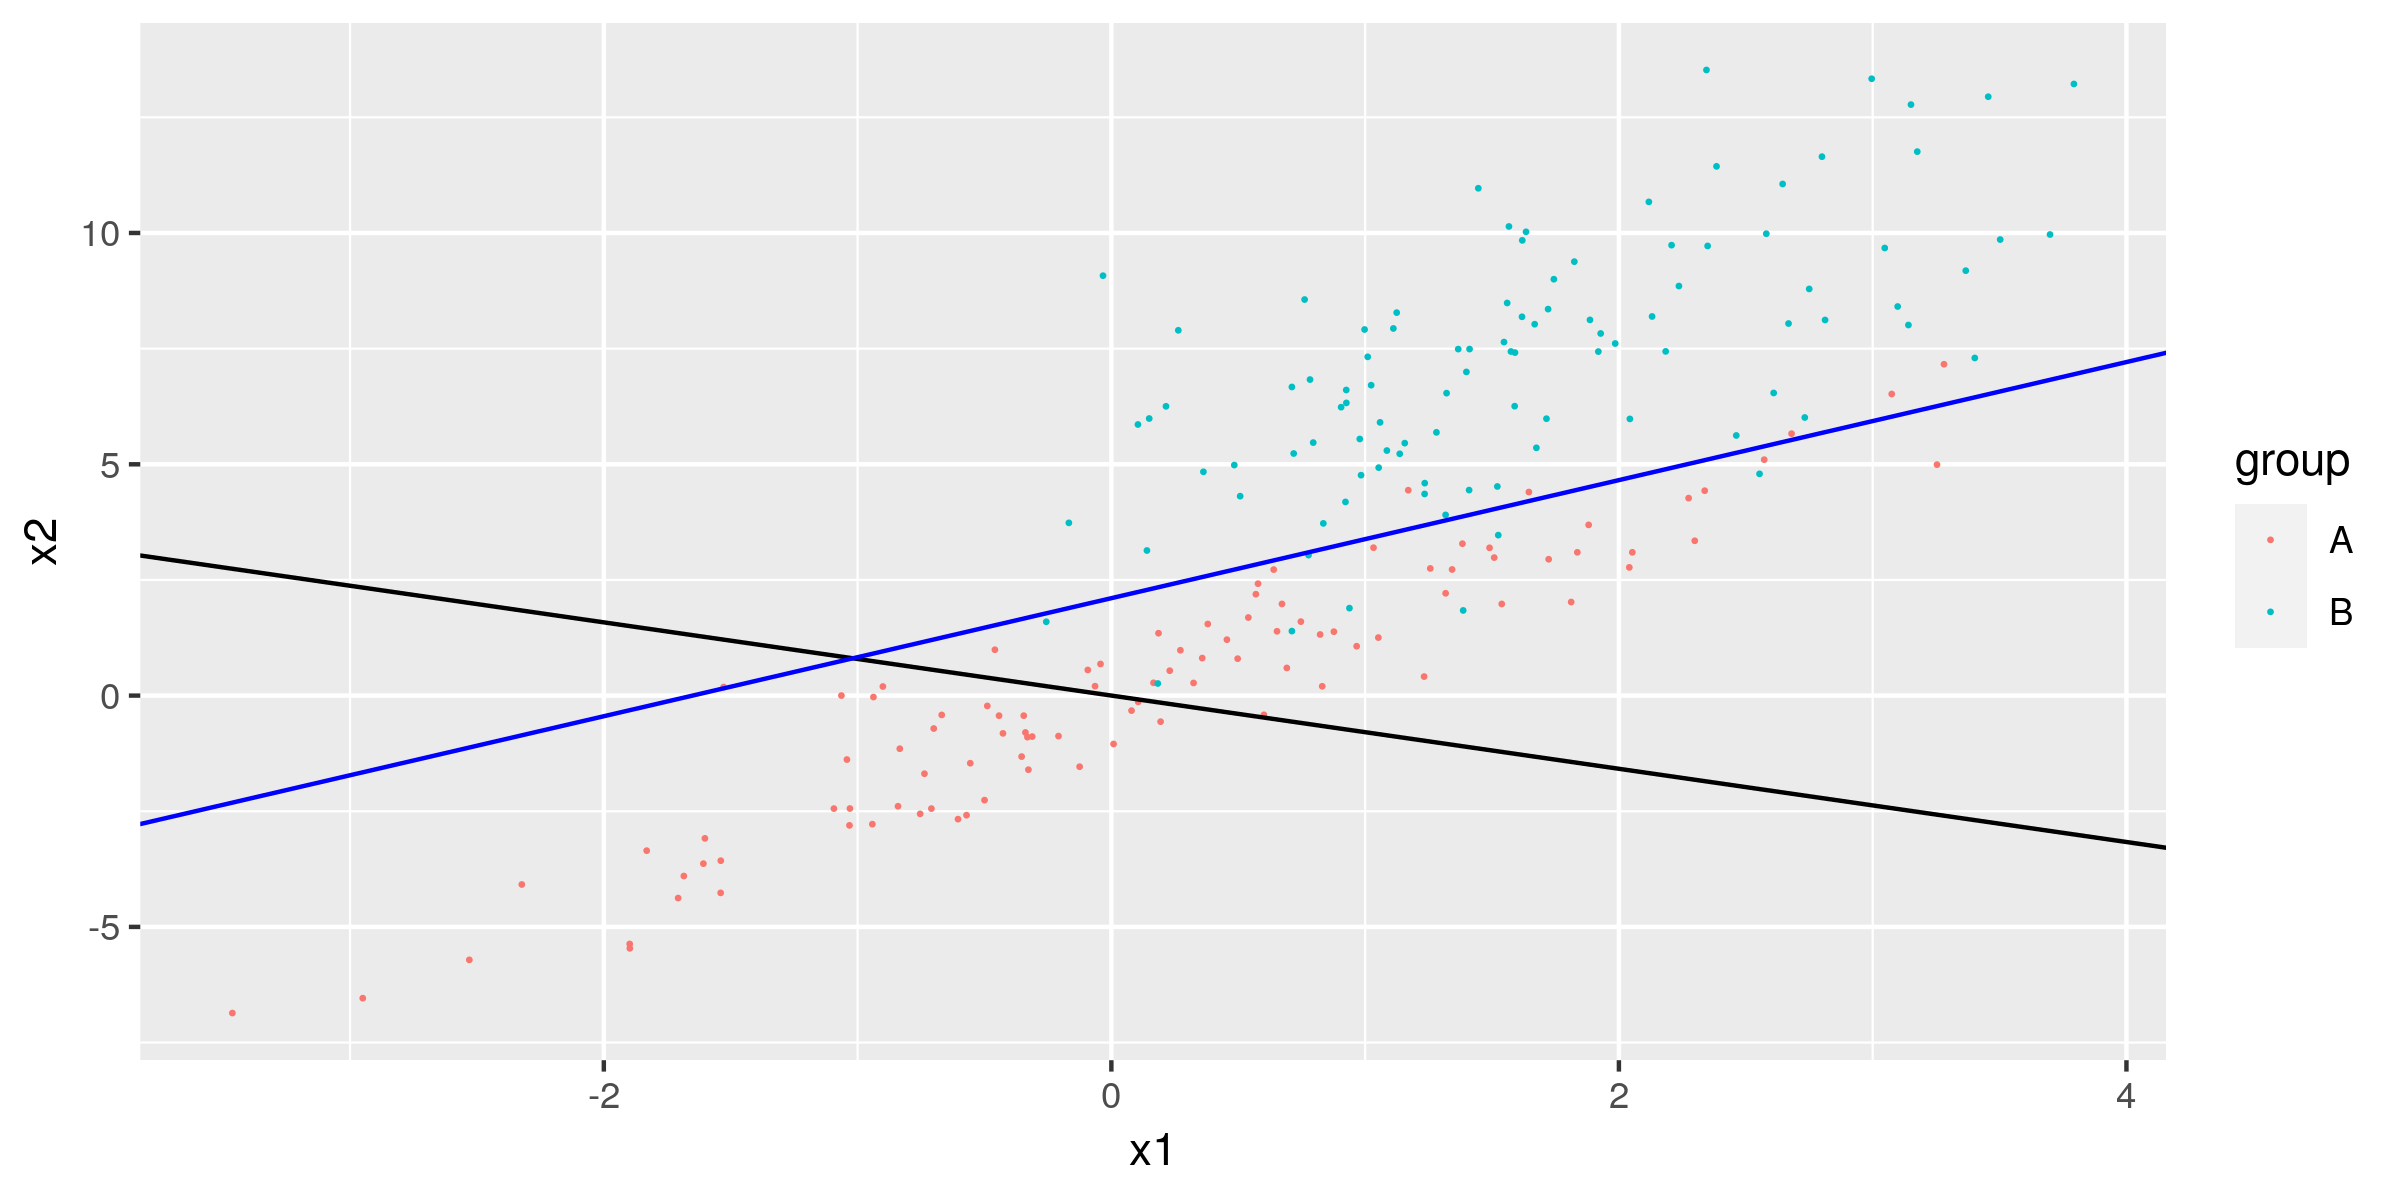

In [18]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])+
geom_abline(intercept = -betalg[1]/betalg[3],slope = -betalg[2]/betalg[3], color="blue" )    
g1

Aunque no lo parezca por la perspectiva de la gráfica, ambas rectas son orgonales. El vector que define la pendiente de la curva dada por $\beta$ es el mismo que el vector $\vec w$:

In [ ]:
model_glm$coefficients

In [19]:
b<-model_glm$coefficients[c("x1","x2")]
b<-b/sqrt(sum(b^2))
b

x1         x2 
-0.7870876  0.6168413

In [20]:
w

x1,-0.7841725
x2,0.6205429


![](#https://media2.giphy.com/media/Z5HVfEvnxr67u/giphy.gif)

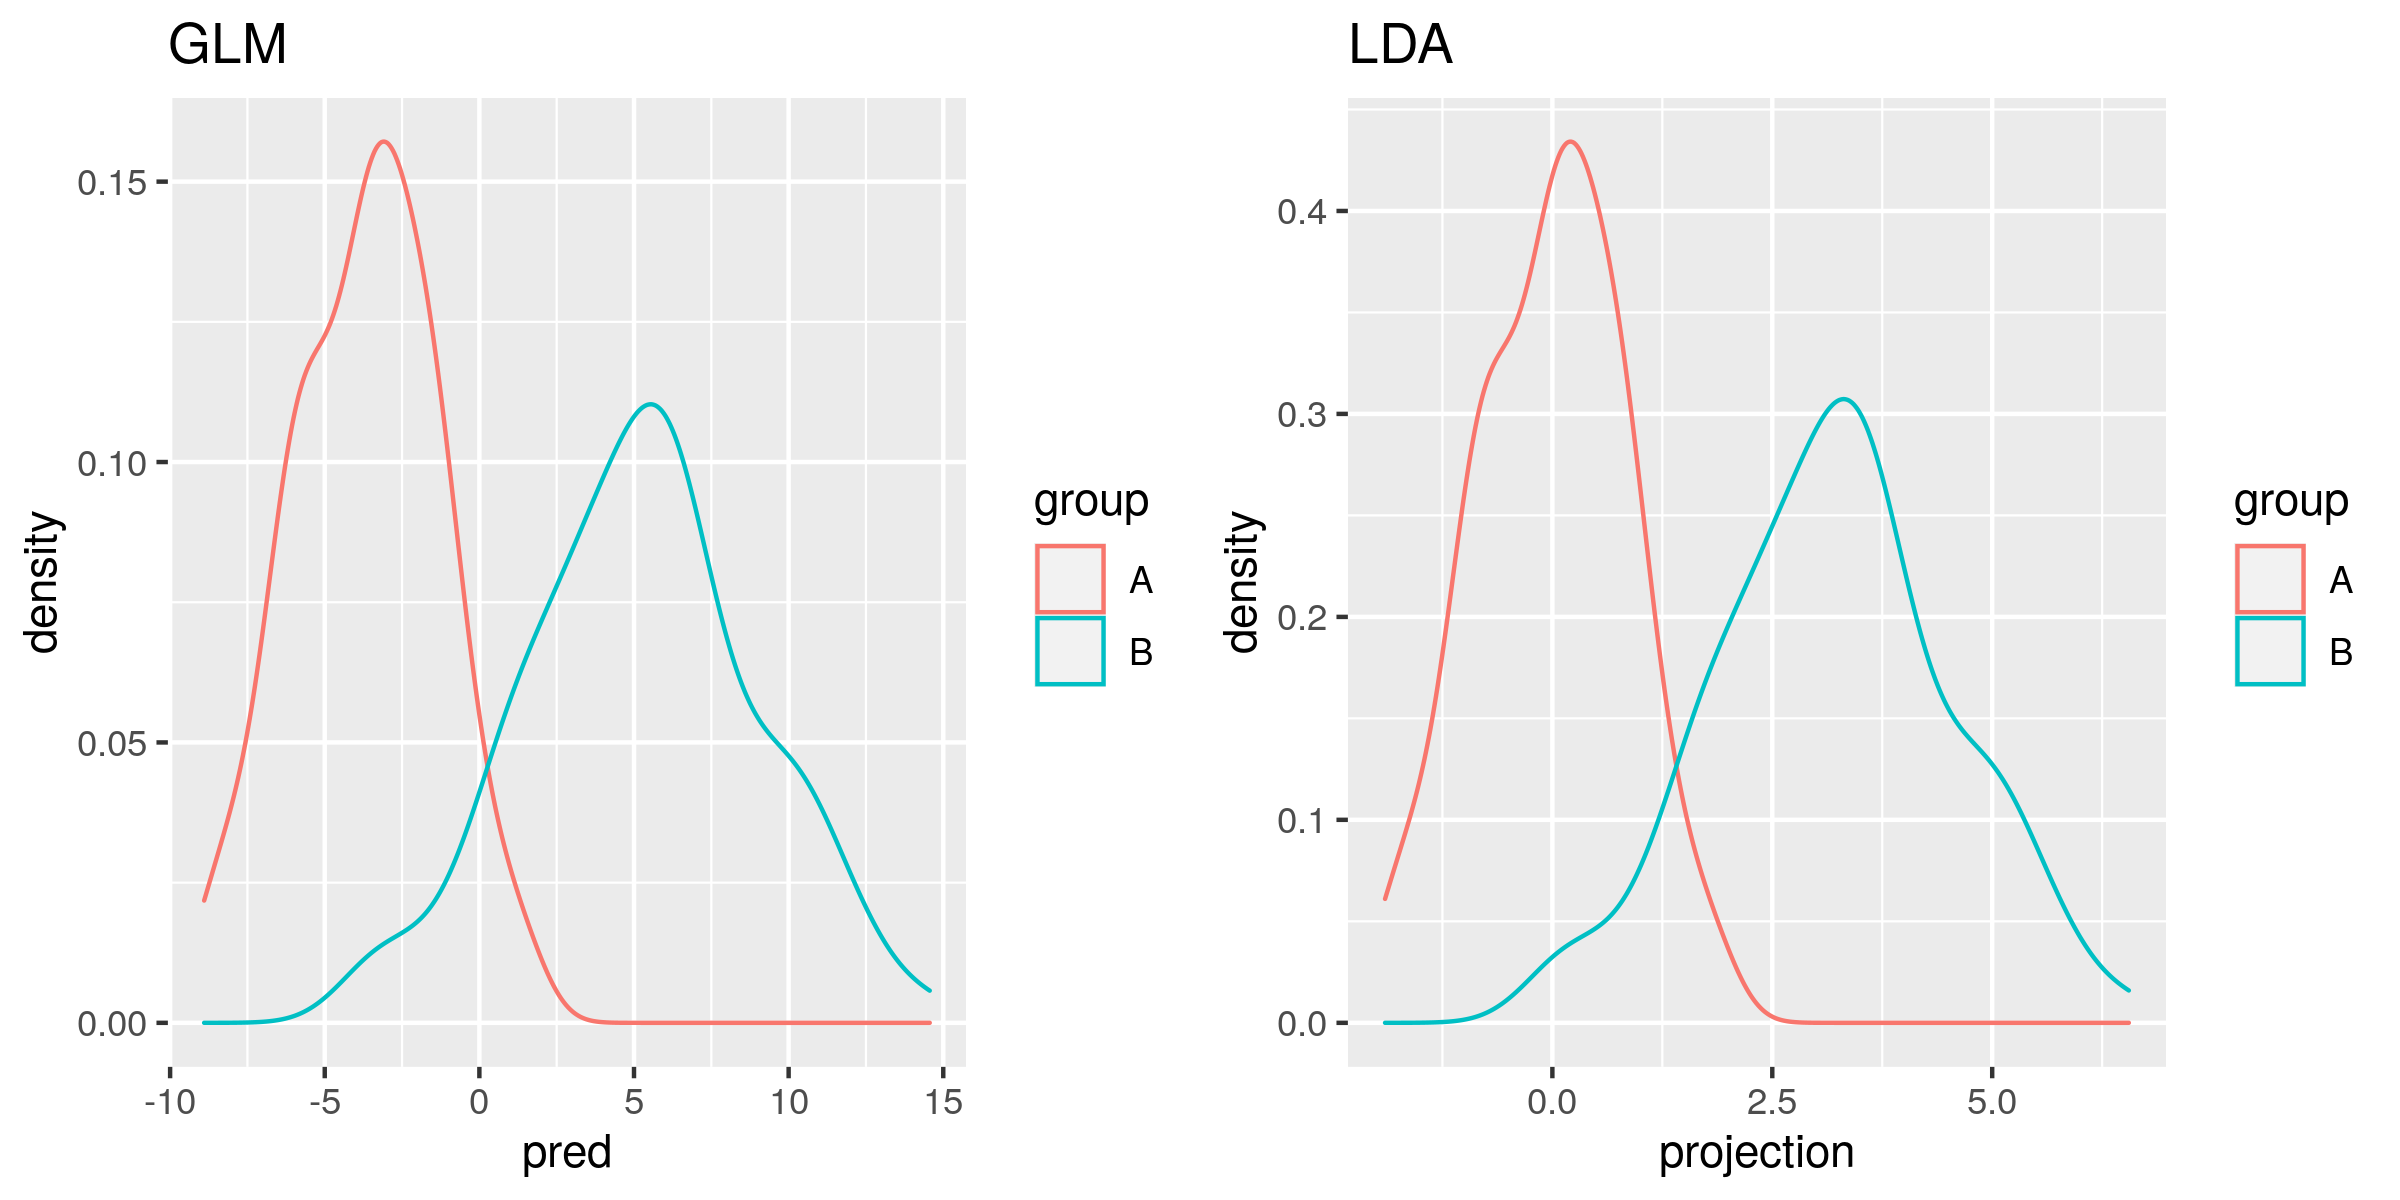

In [21]:
df_glm<-df
df_glm$pred<-predict(model_glm,df)

g1<-ggplot(df_glm,aes(x=pred,color=group))+geom_density()+ggtitle("GLM")
df$projection<-as.matrix(df[,2:3]) %*% w#l$scaling# w
#df$projection<-predict(l,df)$x+th
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()+ggtitle("LDA")

ggarrange(g1,g2,ncol = 2)

### Ejemplo Iris

Vamos a utilizar el dataset Iris para ver si somos capaces de diferenciar una clase del resto

In [22]:
idx<-sample(1:nrow(iris),nrow(iris)*0.7)
iris_train<-iris[idx,]
iris_test<-iris[-idx,]

**Forma manual**

In [23]:
iris_class<-'virginica'
X<-iris_train[,1:4]
X<-as.matrix(X)
y<-as.matrix(ifelse(iris_train$Species==iris_class,1,0))

In [24]:
mA<-colMeans(X[y==1,])
mB<-colMeans(X[y==0,])

xA<-t(X[y==1,])
xB<-t(X[y==0,])
      
mA_rep<-matrix(rep(mA,each=ncol(xA)), ncol=ncol(xA), byrow=TRUE)
mB_rep<-matrix(rep(mB,each=ncol(xB)), ncol=ncol(xB), byrow=TRUE)

Sw<-(xA-mA_rep) %*% t(xA-mA_rep)+(xB-mB_rep) %*% t(xB-mB_rep)

In [25]:
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,37.296036,-3.203621,61.85679,20.816843
Sepal.Width,-3.203621,17.863297,-27.13415,-9.396645
Petal.Length,61.856794,-27.134151,161.32857,58.984093
Petal.Width,20.816843,-9.396645,58.98409,25.151781


In [26]:
w<-solve(Sw) %*% (mB-mA)
w

Sepal.Length,-0.009198153
Sepal.Width,-0.014322990
Petal.Length,0.012299725
Petal.Width,-0.073910831


In [27]:
X_test<-iris_test[,1:4]
X_test<-as.matrix(X_test)
y_test<-as.matrix(ifelse(iris_test$Species==iris_class,1,0))

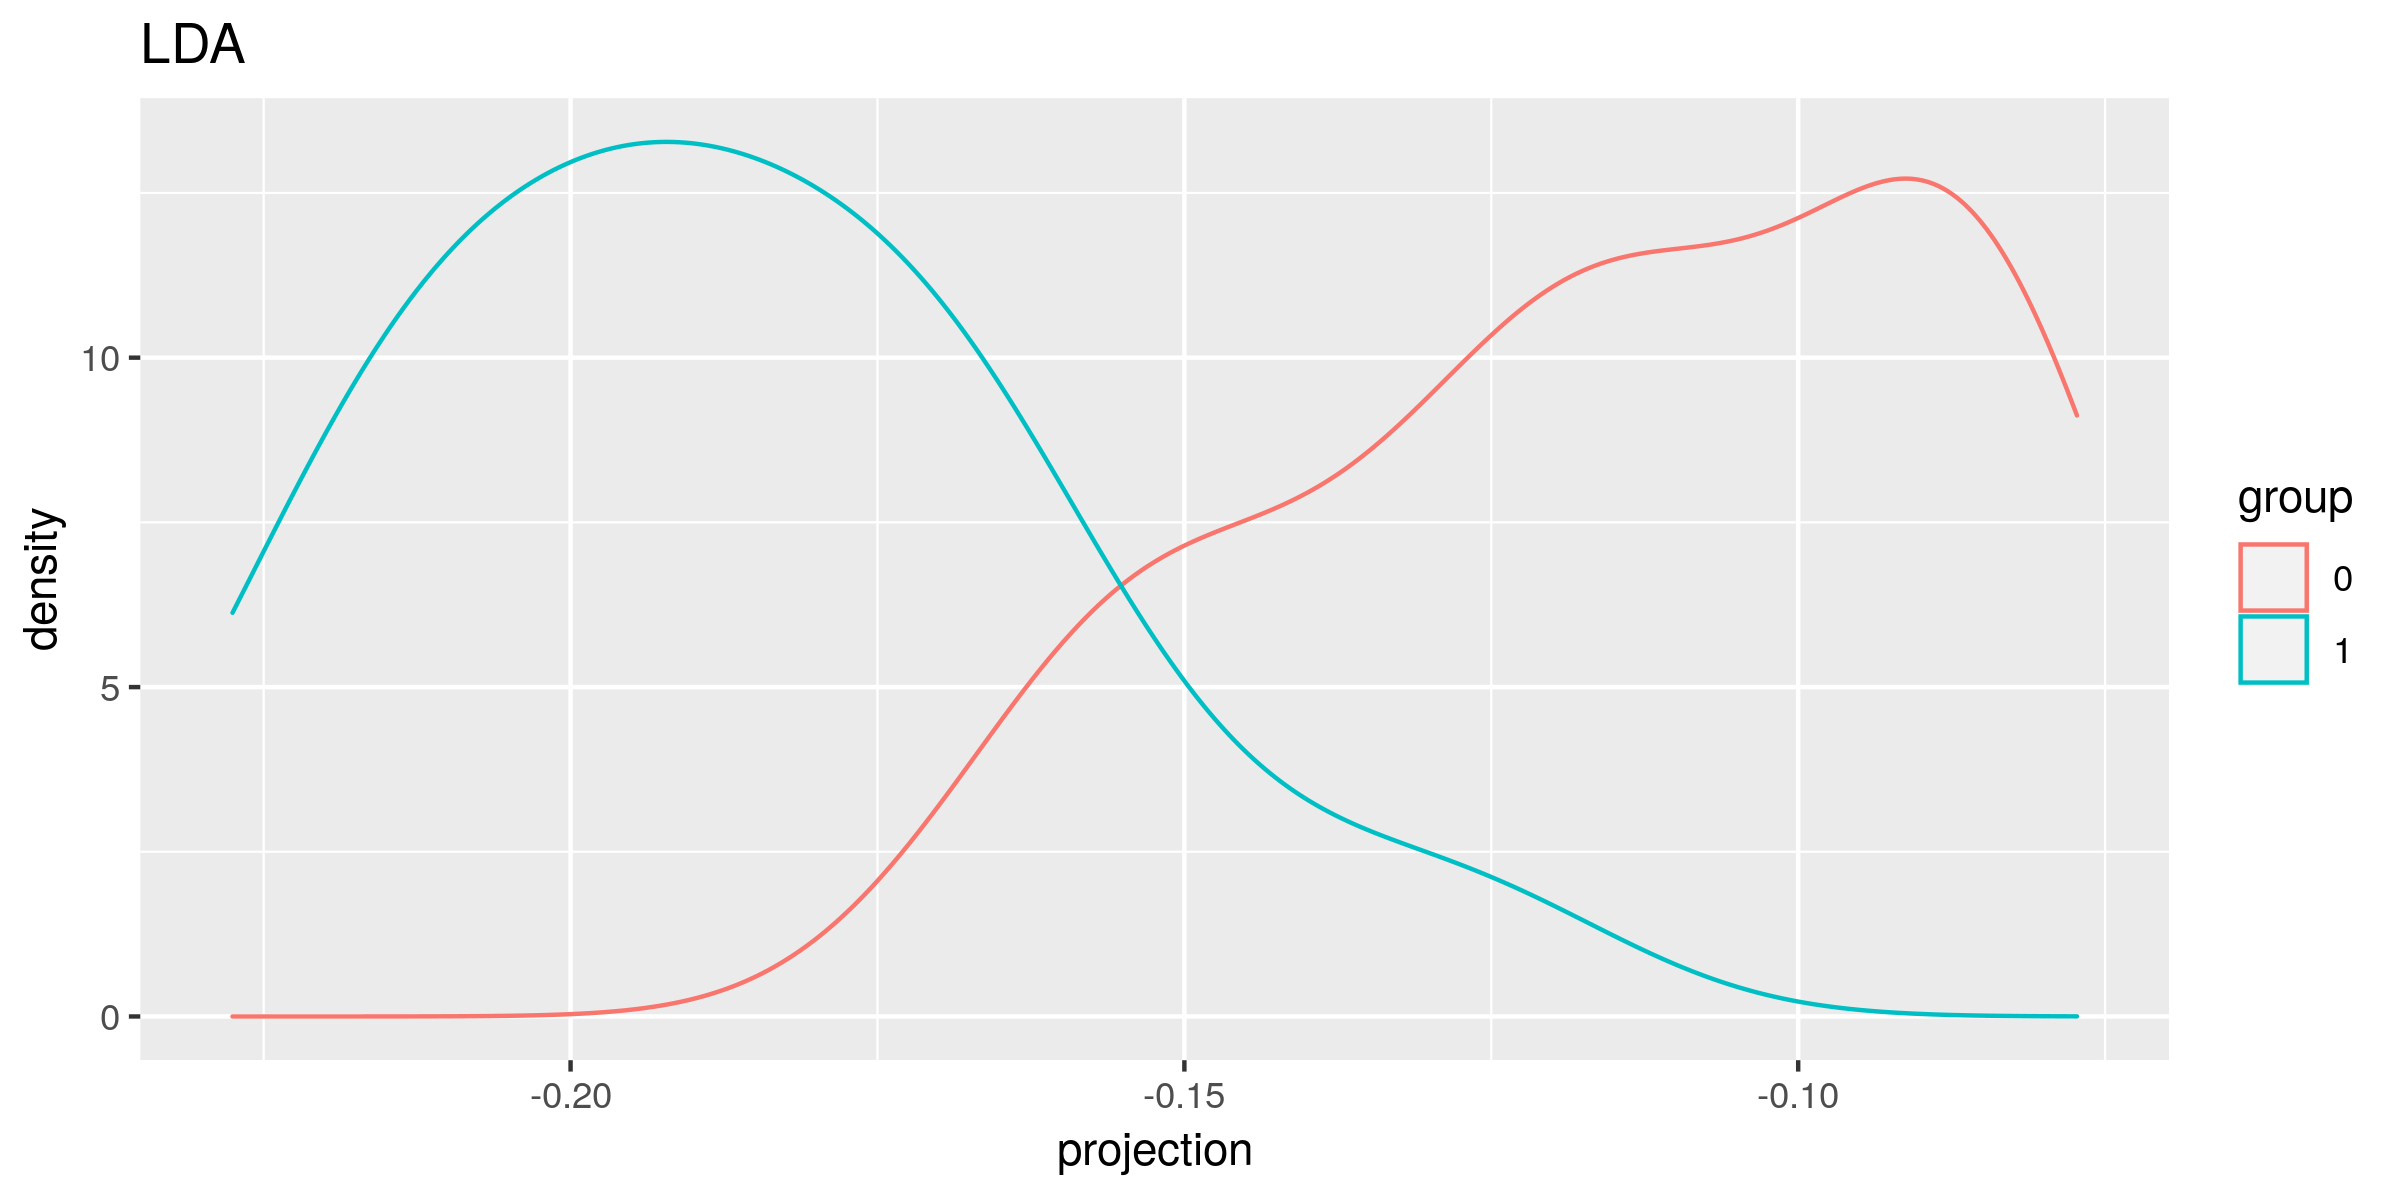

In [28]:
df=data.frame(projection=X_test %*% w,group=factor(y_test))
ggplot(df,aes(x=projection,color=group))+geom_density()+ggtitle("LDA")

**Usando función de R**

In [29]:
iris_class<-'virginica'
iris_train$class<-(ifelse(iris_train$Species==iris_class,1,0))
iris_test$class<-(ifelse(iris_test$Species==iris_class,1,0))
summary(iris_test)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.400   Min.   :2.300   Min.   :1.300   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.200  
 Median :5.700   Median :3.000   Median :4.200   Median :1.300  
 Mean   :5.836   Mean   :3.089   Mean   :3.767   Mean   :1.196  
 3rd Qu.:6.400   3rd Qu.:3.400   3rd Qu.:5.400   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species       class       
 setosa    :16   Min.   :0.0000  
 versicolor:13   1st Qu.:0.0000  
 virginica :16   Median :0.0000  
                 Mean   :0.3556  
                 3rd Qu.:1.0000  
                 Max.   :1.0000  

In [30]:
l<-lda(class~Sepal.Length+Sepal.Width+Petal.Length+Petal.Width,data=iris_train)
l

Call:
lda(class ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
    data = iris_train)

Prior probabilities of groups:
        0         1 
0.6761905 0.3238095 

Group means:
  Sepal.Length Sepal.Width Petal.Length Petal.Width
0     5.498592    3.087324     2.926761    0.815493
1     6.573529    2.952941     5.482353    2.005882

Coefficients of linear discriminants:
                    LD1
Sepal.Length  0.3675345
Sepal.Width   0.5723098
Petal.Length -0.4914653
Petal.Width   2.9532863

In [31]:
l$scaling/sqrt(sum(l$scaling^2))

,LD1
Sepal.Length,0.1197107
Sepal.Width,0.1864087
Petal.Length,-0.1600766
Petal.Width,0.9619234


In [ ]:
w/sqrt(sum(w^2))

In [32]:
df=data.frame(projection=unname(predict(l,iris_test)$x),group=factor(iris_test$class))
head(df)

,projection,group
,<dbl>,<fct>
1,-1.0299907,0
2,-2.4130527,0
3,-2.5041365,0
4,-0.5352824,0
5,-1.9068029,0
6,-1.1564200,0


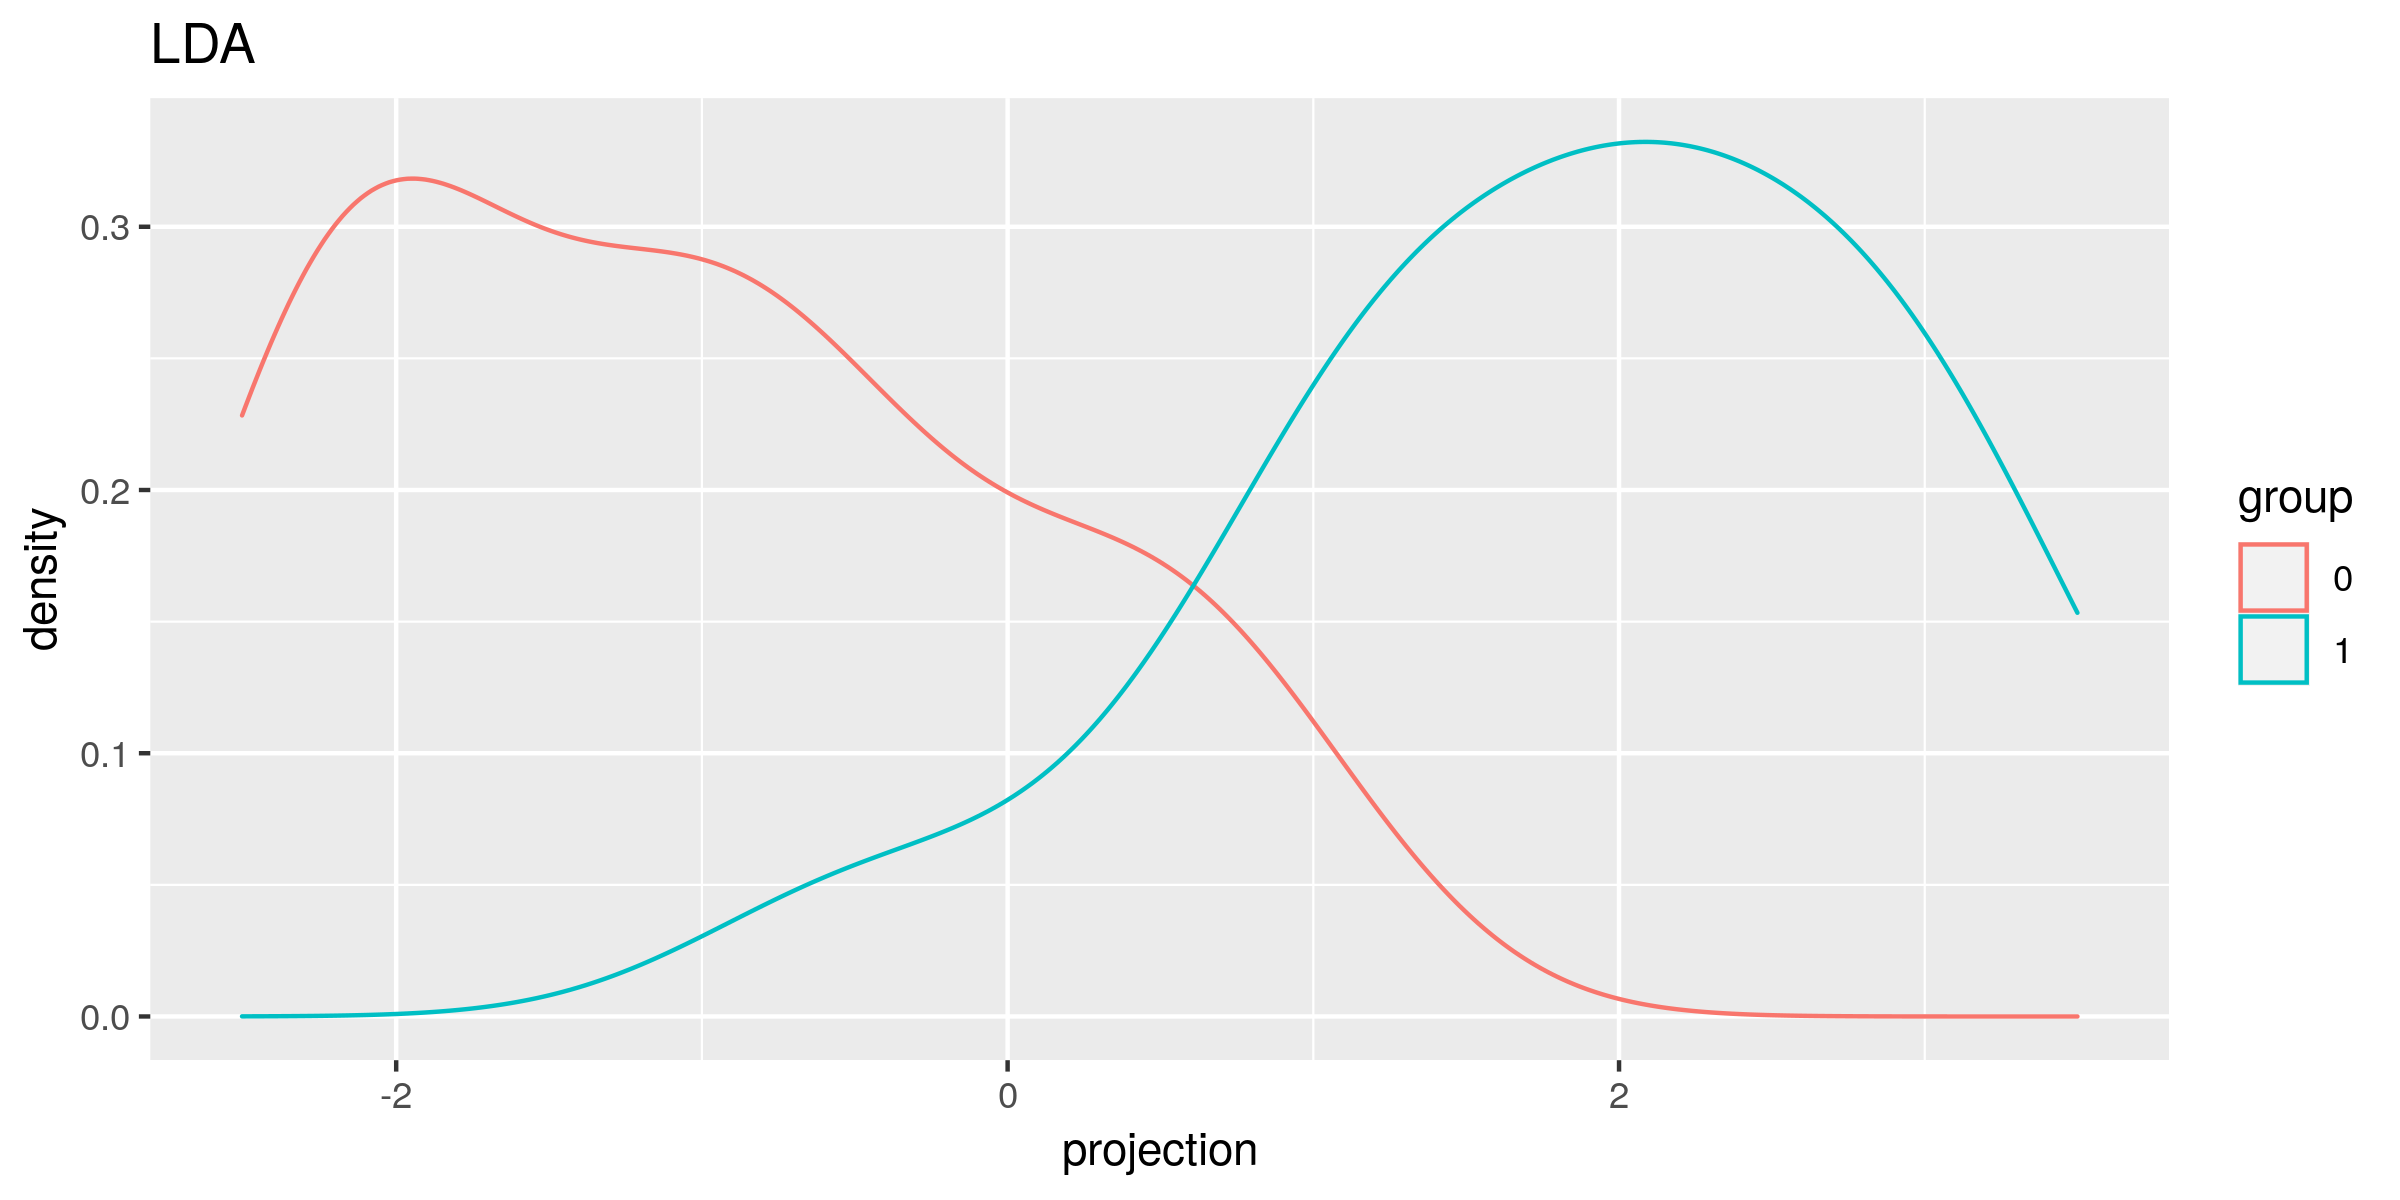

In [33]:

ggplot(df,aes(x=projection,color=group))+geom_density()+ggtitle("LDA")

## LDA para clases múltiples

Consideremos que tenemos dos clases y un vector sobre el que proyectaremos las dos clases, de tal forma que podamos resumir el valor de cada muestra en una sola dimensión. 
\\[
\vec y = X · \vec{w}
\\]
Donde
* X son los datos que queremos clasificar $X \in \mathbb{R}^{N\times p}$
* w es el vector de proyección, $w \in \mathbb{R}^{p\times1}$
* y son los datos proyectados, $y \in \mathbb{R}^{N\times1}$

Podemos generalizar a $K$ clases el problema suponiendo que $y$ tiene más columnas, una por cada clase que queremos clasificar:
\\[
\vec y_k = X · \vec{w_k}
\\]
* $w_k$ es el vector de proyección, $w \in \mathbb{R}^{p\times1}$ que diferencia la clase $k$ del resto
* $y_k$ son los datos proyectados que maximizan la separación entre la clase $k$ y el resto, $y_k \in \mathbb{R}^{N\times1}$

Podemos crear la matrix $Y$ combinando todas las $y_k$:
\\[
\vec Y = X · W
\\]
* $W$ es la matriz de proyección, $w \in \mathbb{R}^{p\times K}$
* $Y$ son los datos proyectados de tal forma que cada columa $k$ maximiza la separación entre la clase $k$ y el resto, $Y \in \mathbb{R}^{N\times K}$

Recordemos que Fisher lo que busca es el máximo del cociente:
\\[
    J(w)=\frac{\sigma_{entre ~ clases}}{\sigma_{dentro ~ clases}} =\frac{ |\vec w^T S_{between} \vec w|}{|\vec w^T S_{within} \vec w |}  = Tr \left\{ \left( \vec w^T S_{within} \vec w \right)^{-1} \left( \vec w^T S_{between} \vec w \right) \right\}
\\]

Definimos la media global y para cada clase:
\\[
\vec \mu= \frac{1}{N}\sum_{i\in N} x_i ~~~~~~~~~ \vec \mu \in \mathbb{R}^{p\times 1}\\
\vec \mu_k= \frac{1}{N_k}\sum_{i\in C_k} x_i  ~~~~~~~~~  \vec \mu_k \in \mathbb{R}^{p\times 1}
\\]

Donde $S_{between}$ es la varianza que hay entre clases. Como se separa cada clase de la media global.

Para dos clases era:
\\[
S_{between} = (\vec m_B - \vec m_A)(\vec m_B - \vec m_A)^T
\\]
La generalización para K clases es:
\\[
S_{between} = \sum_{k=1}^K N_k (\vec \mu_k - \vec \mu)(\vec \mu_k - \vec \mu)^T ~~~~~~~~~ S_{between} \in \mathbb{R}^{p\times p}\\
\\]


Donde $S_{within}$ es la suma de las varianzas de cada grupo. Como varían las muestras dentro de cada clase:

Para dos clases era:
\\[
S_{within} = \sum_{n \in C_A} (\vec x_n - m_A)(\vec x_n - m_A)^T + \sum_{n \in C_B} (\vec x_n - m_B)(\vec x_n - m_B)^T
\\]
La generalización para K clases es:
\\[
S_{within} = \sum_{k=1}^K \sum_{i\in C_k} (\vec x_i - \vec \mu_k)(\vec x_i - \vec \mu_k)^T ~~~~~~~~~\vec x_i \in \mathbb{R}^{p\times 1} ~~~  S_{within} \in \mathbb{R}^{p\times p}\\
\\]

El máximo de J(w) se consigue cuando:
\\[
S_{between}·W = \lambda S_{within} · W \\
 S_{within}^{-1} S_{between} W = \lambda W
\\]
La solución viene dada por los autovectores, de cuyos K-1 autovalores son mayores.

In [34]:
idx<-sample(1:nrow(iris),nrow(iris)*0.7)
iris_train<-iris[idx,]
iris_test<-iris[-idx,]

X<-iris_train[,1:4]
X<-as.matrix(X)
Cl<-iris_train$Species
p<-ncol(X)

In [35]:
table(Cl)

Cl
    setosa versicolor  virginica 
        36         34         35 

In [36]:
mu<-colMeans(X)
Sb=matrix(0L, nrow = p, ncol = p) 
for (k in levels(Cl)){
    mu_k=colMeans(X[Cl==k,])
    N_k=sum(Cl==k)
    Sb=Sb+N_k*(mu_k-mu) %*% t(mu_k-mu)
}
Sb

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
49.38560,-14.336505,125.56816,53.56521
-14.33651,6.535652,-37.95786,-15.19440
125.56816,-37.957862,320.22563,135.96981
53.56521,-15.194402,135.96981,58.15176


In [37]:
Sw<-matrix(0L, nrow=p, ncol=p)
for (k in levels(Cl)){
    X_k<-X[Cl==k,]
    mu_k=colMeans(X[Cl==k,])
    for (i in 1:nrow(X_k)){
        X_i<-as.matrix(X_k[i,])        
        Sw<-Sw+(X_i-mu_k) %*% t(X_i-mu_k)
    }
}
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,31.414023,10.773743,19.568601,4.345937
Sepal.Width,10.773743,12.046824,6.269386,3.002688
Petal.Length,19.568601,6.269386,20.456850,4.589908
Petal.Width,4.345937,3.002688,4.589908,4.104808


In [38]:
#Se puede calcular Sw de una forma más eficiente pensando :

Sw<-matrix(0L, nrow=p, ncol=p)
for (k in levels(Cl)){
    X_k<-X[Cl==k,]
    mu_k=colMeans(X[Cl==k,])
    
    mu_krep<-matrix(rep(mu_k,each=nrow(X_k)), ncol=nrow(X_k), byrow=TRUE)
    X_k<-t(as.matrix(X_k))
    Sw<-Sw+(X_k-mu_krep) %*% t(X_k-mu_krep)
    
}
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,31.414023,10.773743,19.568601,4.345937
Sepal.Width,10.773743,12.046824,6.269386,3.002688
Petal.Length,19.568601,6.269386,20.456850,4.589908
Petal.Width,4.345937,3.002688,4.589908,4.104808


In [39]:
(solve(Sw) %*% Sb)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,-3.551967,1.048008,-9.041965,-3.850050
Sepal.Width,-5.265078,1.785983,-13.550392,-5.672111
Petal.Length,8.695213,-2.713530,22.228609,9.402759
Petal.Width,10.938634,-3.083427,27.754270,11.878174


In [40]:
eig<-eigen(solve(Sw) %*% Sb)
eig

eigen() decomposition
$values
[1] 3.207618e+01 2.646130e-01 8.964647e-15 3.132160e-15

$vectors
           [,1]       [,2]       [,3]       [,4]
[1,] -0.2311422  0.1028025 -0.3604214 -0.8384846
[2,] -0.3469821 -0.5857503 -0.2882587  0.2961377
[3,]  0.5686114  0.2181866 -0.2537790  0.4300668
[4,]  0.7091247 -0.7737718  0.8500586 -0.1558484


Realmente la proyección óptima debería ser sobre K-1, es decir 2 columnas. 
Con los dos primeros autovectores podríamos definir bien las fronteras de las 3 clases:

In [41]:
W<-Re(eig$vectors[,1:2])
W
head(X %*% W)

-0.2311422,0.1028025
-0.3469821,-0.5857503
0.5686114,0.2181866
0.7091247,-0.7737718


70,0.8357698,-0.8889029
110,2.3279815,-1.9720142
59,1.0056877,-1.0224242
9,-1.0853930,-1.0956378
23,-1.6019535,-1.5723771
25,-1.0670353,-1.2382986


In [42]:
library(MASS)
l<-lda(formula=Species ~ Sepal.Length+Sepal.Width+Petal.Length+Petal.Width, data=iris_train)
l

Call:
lda(Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
    data = iris_train)

Prior probabilities of groups:
    setosa versicolor  virginica 
 0.3428571  0.3238095  0.3333333 

Group means:
           Sepal.Length Sepal.Width Petal.Length Petal.Width
setosa         4.944444    3.361111     1.438889   0.2388889
versicolor     6.002941    2.767647     4.311765   1.3441176
virginica      6.588571    2.945714     5.580000   2.0314286

Coefficients of linear discriminants:
                    LD1        LD2
Sepal.Length  0.9007523  0.4118469
Sepal.Width   1.3521760 -2.3466288
Petal.Length -2.2158567  0.8740975
Petal.Width  -2.7634316 -3.0998795

Proportion of trace:
   LD1    LD2 
0.9918 0.0082 

In [ ]:
W
l$scaling / sqrt(colSums(l$scaling^2))

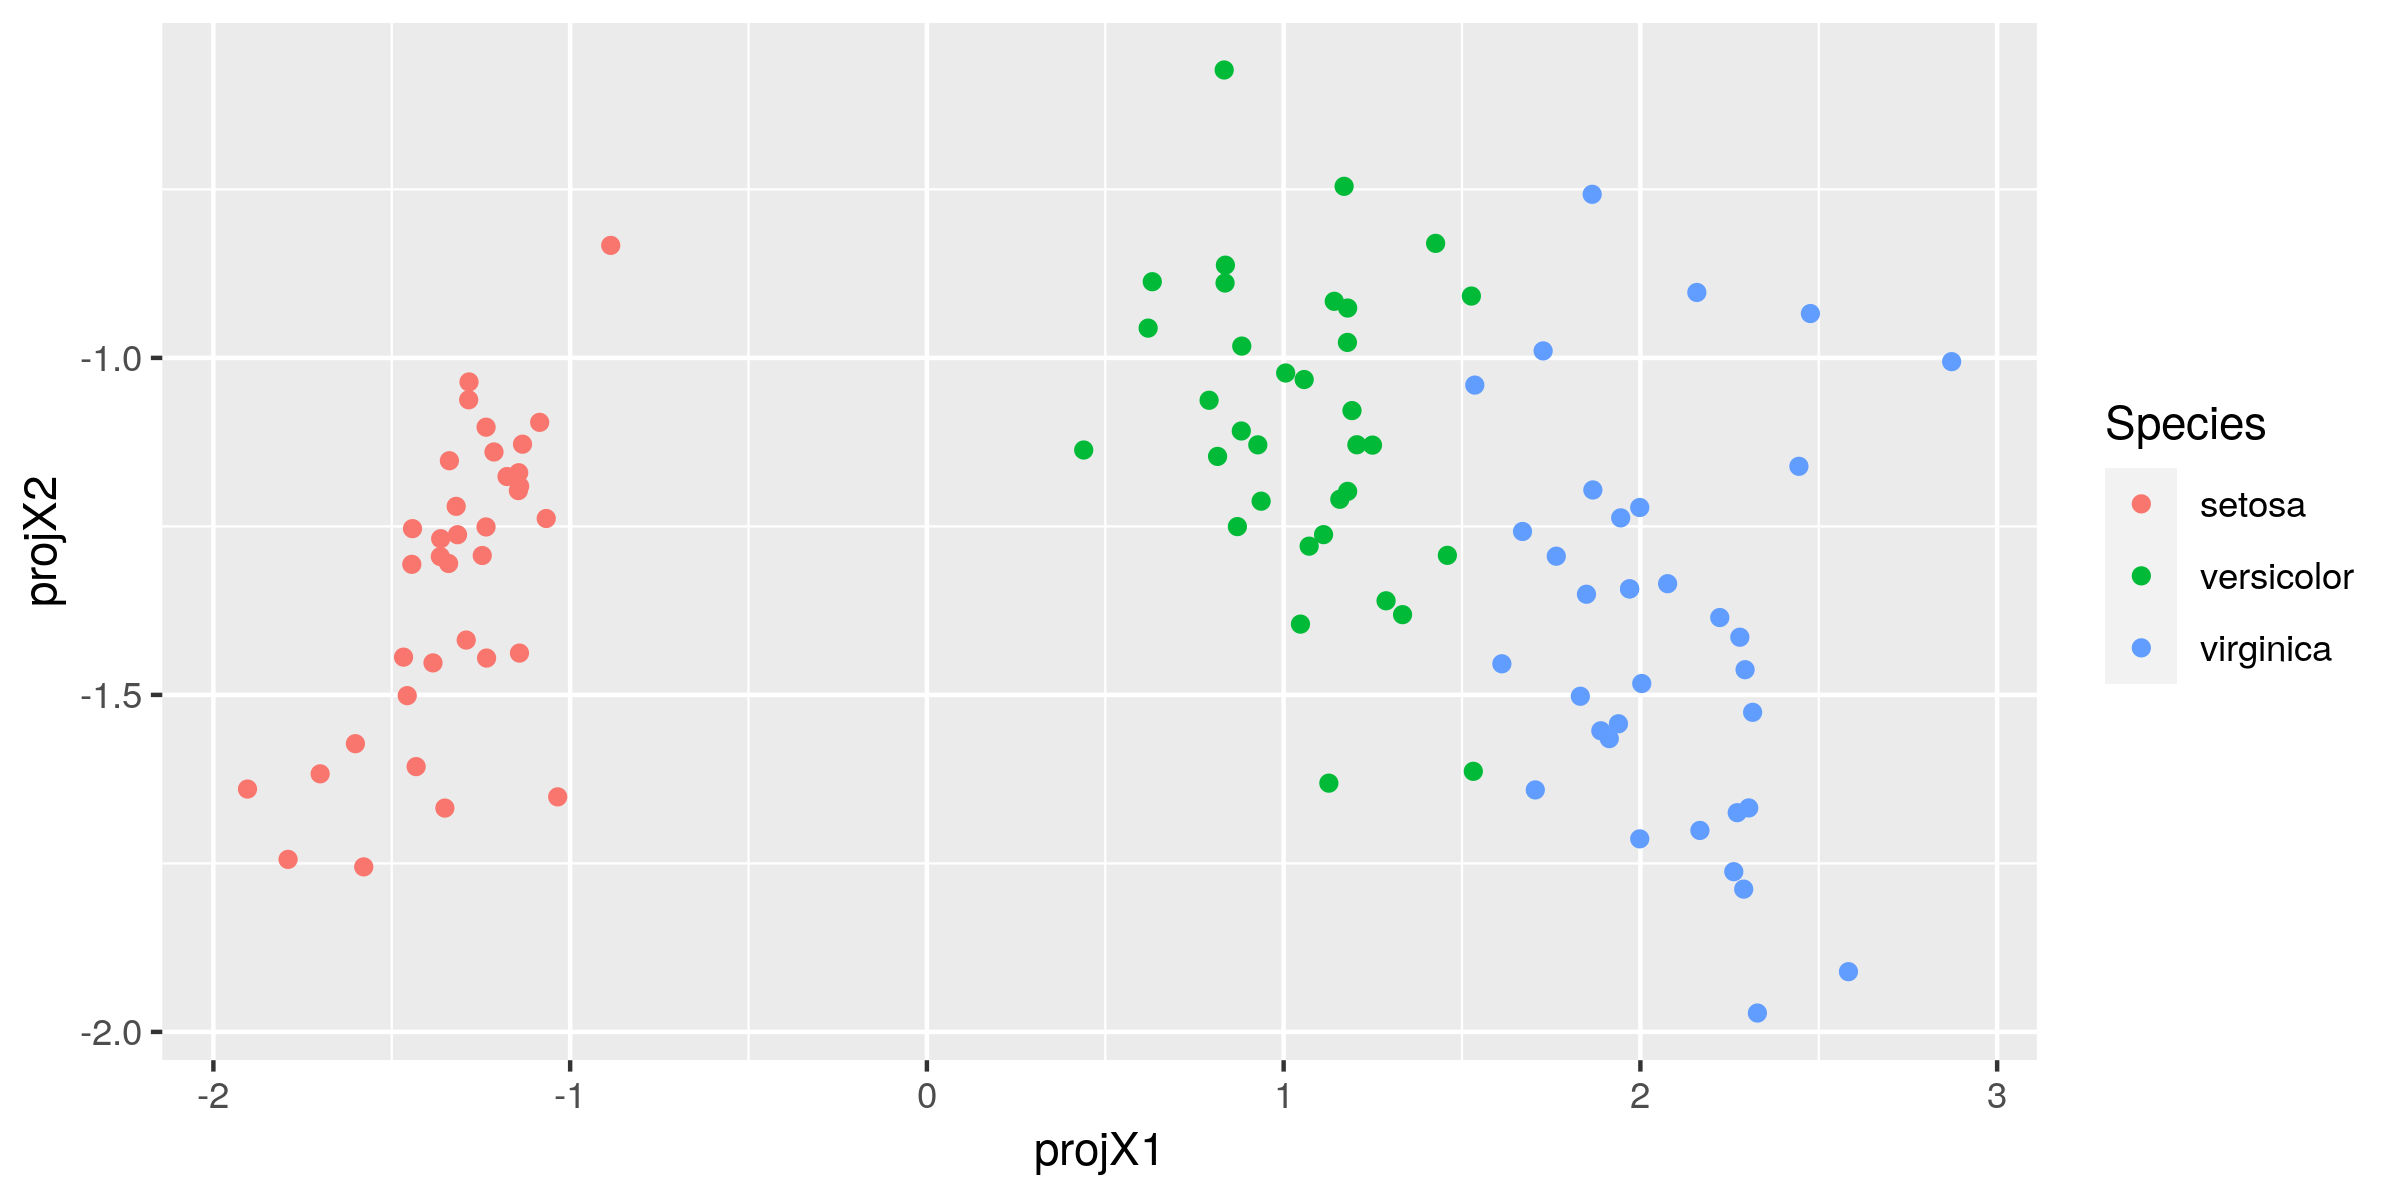

In [43]:
W<-eig$vectors[,1:2]
iris_train[,c("projX1","projX2")]<-Re(X %*% W)
ggplot(iris_train,aes(x=projX1,y=projX2,color=Species))+geom_point()

Como vemos, el mayor poder discriminante se encuenta en la primera proyección que es la que corresponde al autovalor más grande. Esto tiene sentido porque el primer autovector es 100 veces más grande que el segundo. Esto indica que la primera dimensión tiene casi todo el poder discriminante.

Podemos comprobarlo proyectando solo sobre el primer discrimante:

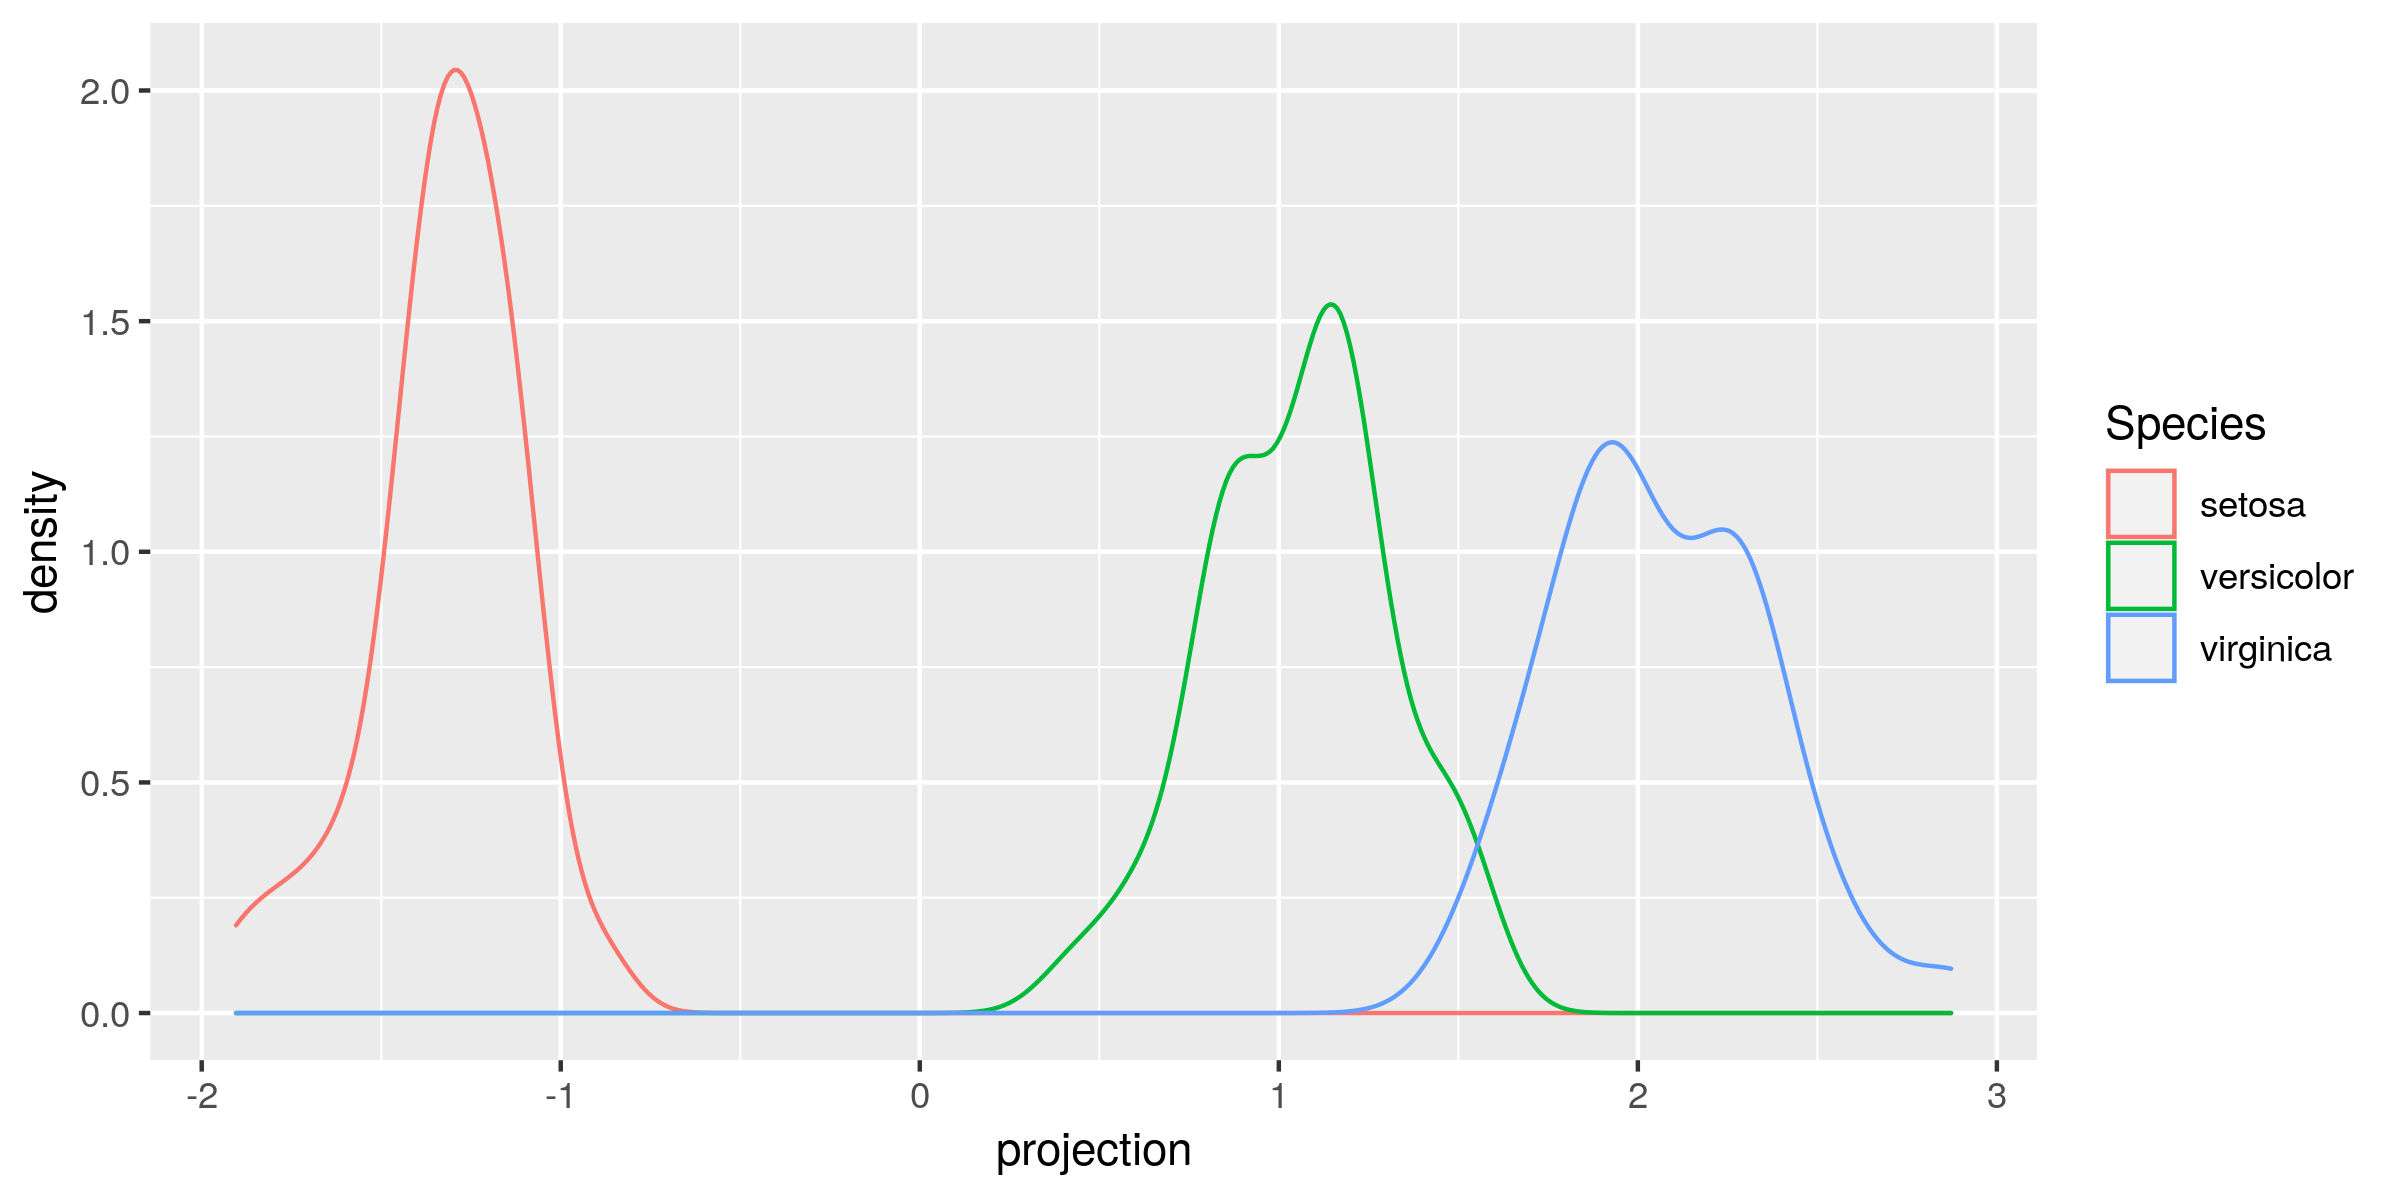

In [44]:
W<-eig$vectors[,1]
iris_train$projection <- Re(X %*% W)
ggplot(iris_train,aes(x=projection,color=Species))+geom_density()

Para el conjunto de training:

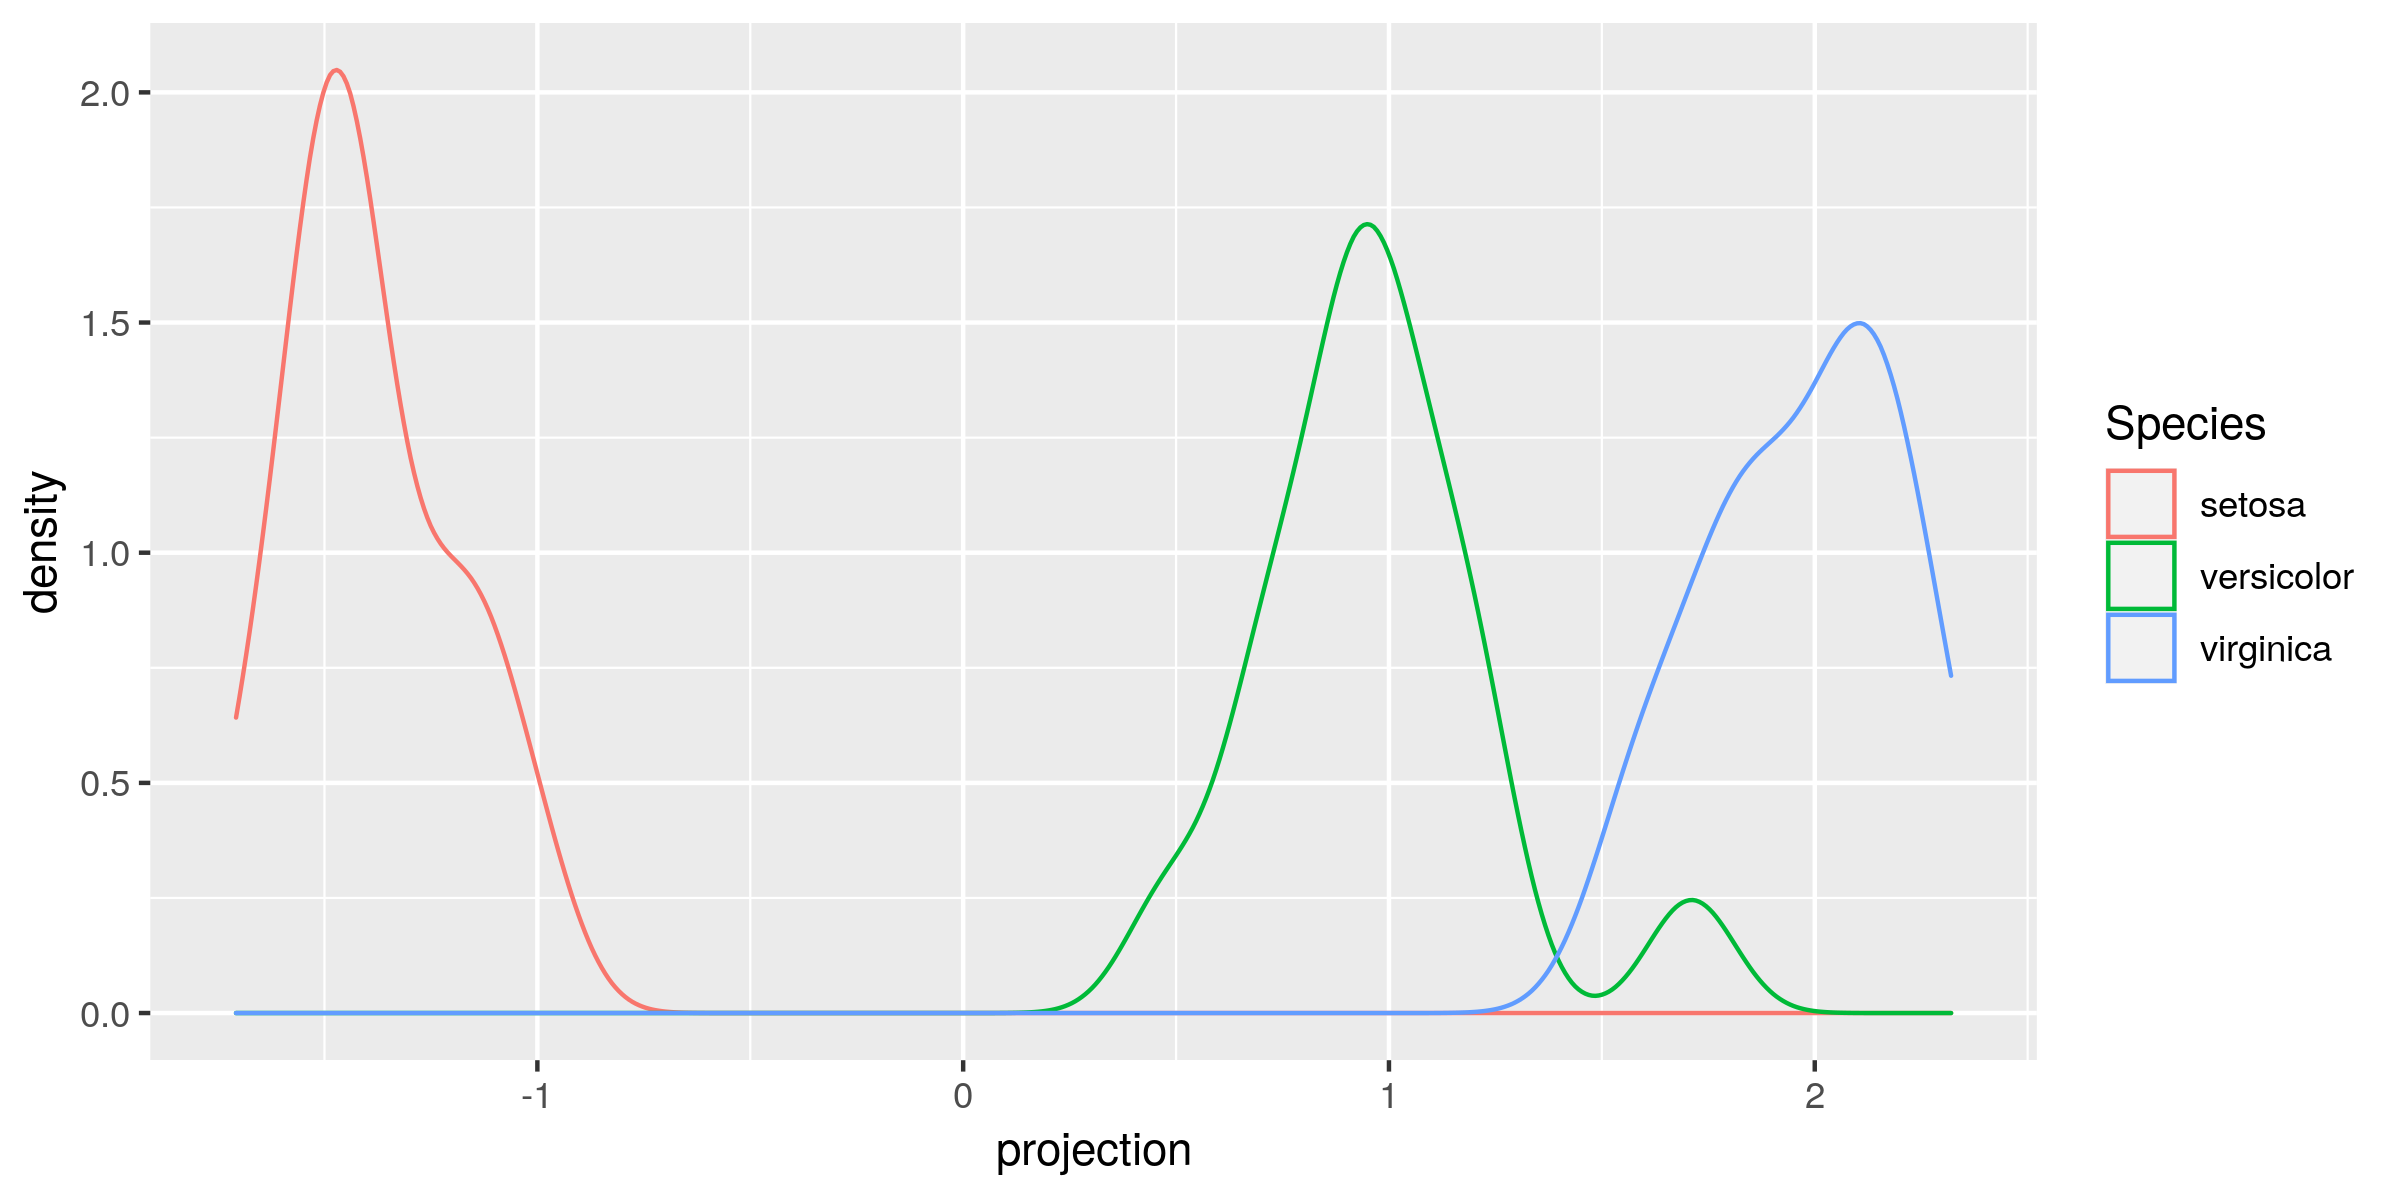

In [45]:
X_test<-as.matrix(iris_test[,1:4])
iris_test$projection <- Re(X_test %*% W)
ggplot(iris_test,aes(x=projection,color=Species))+geom_density()

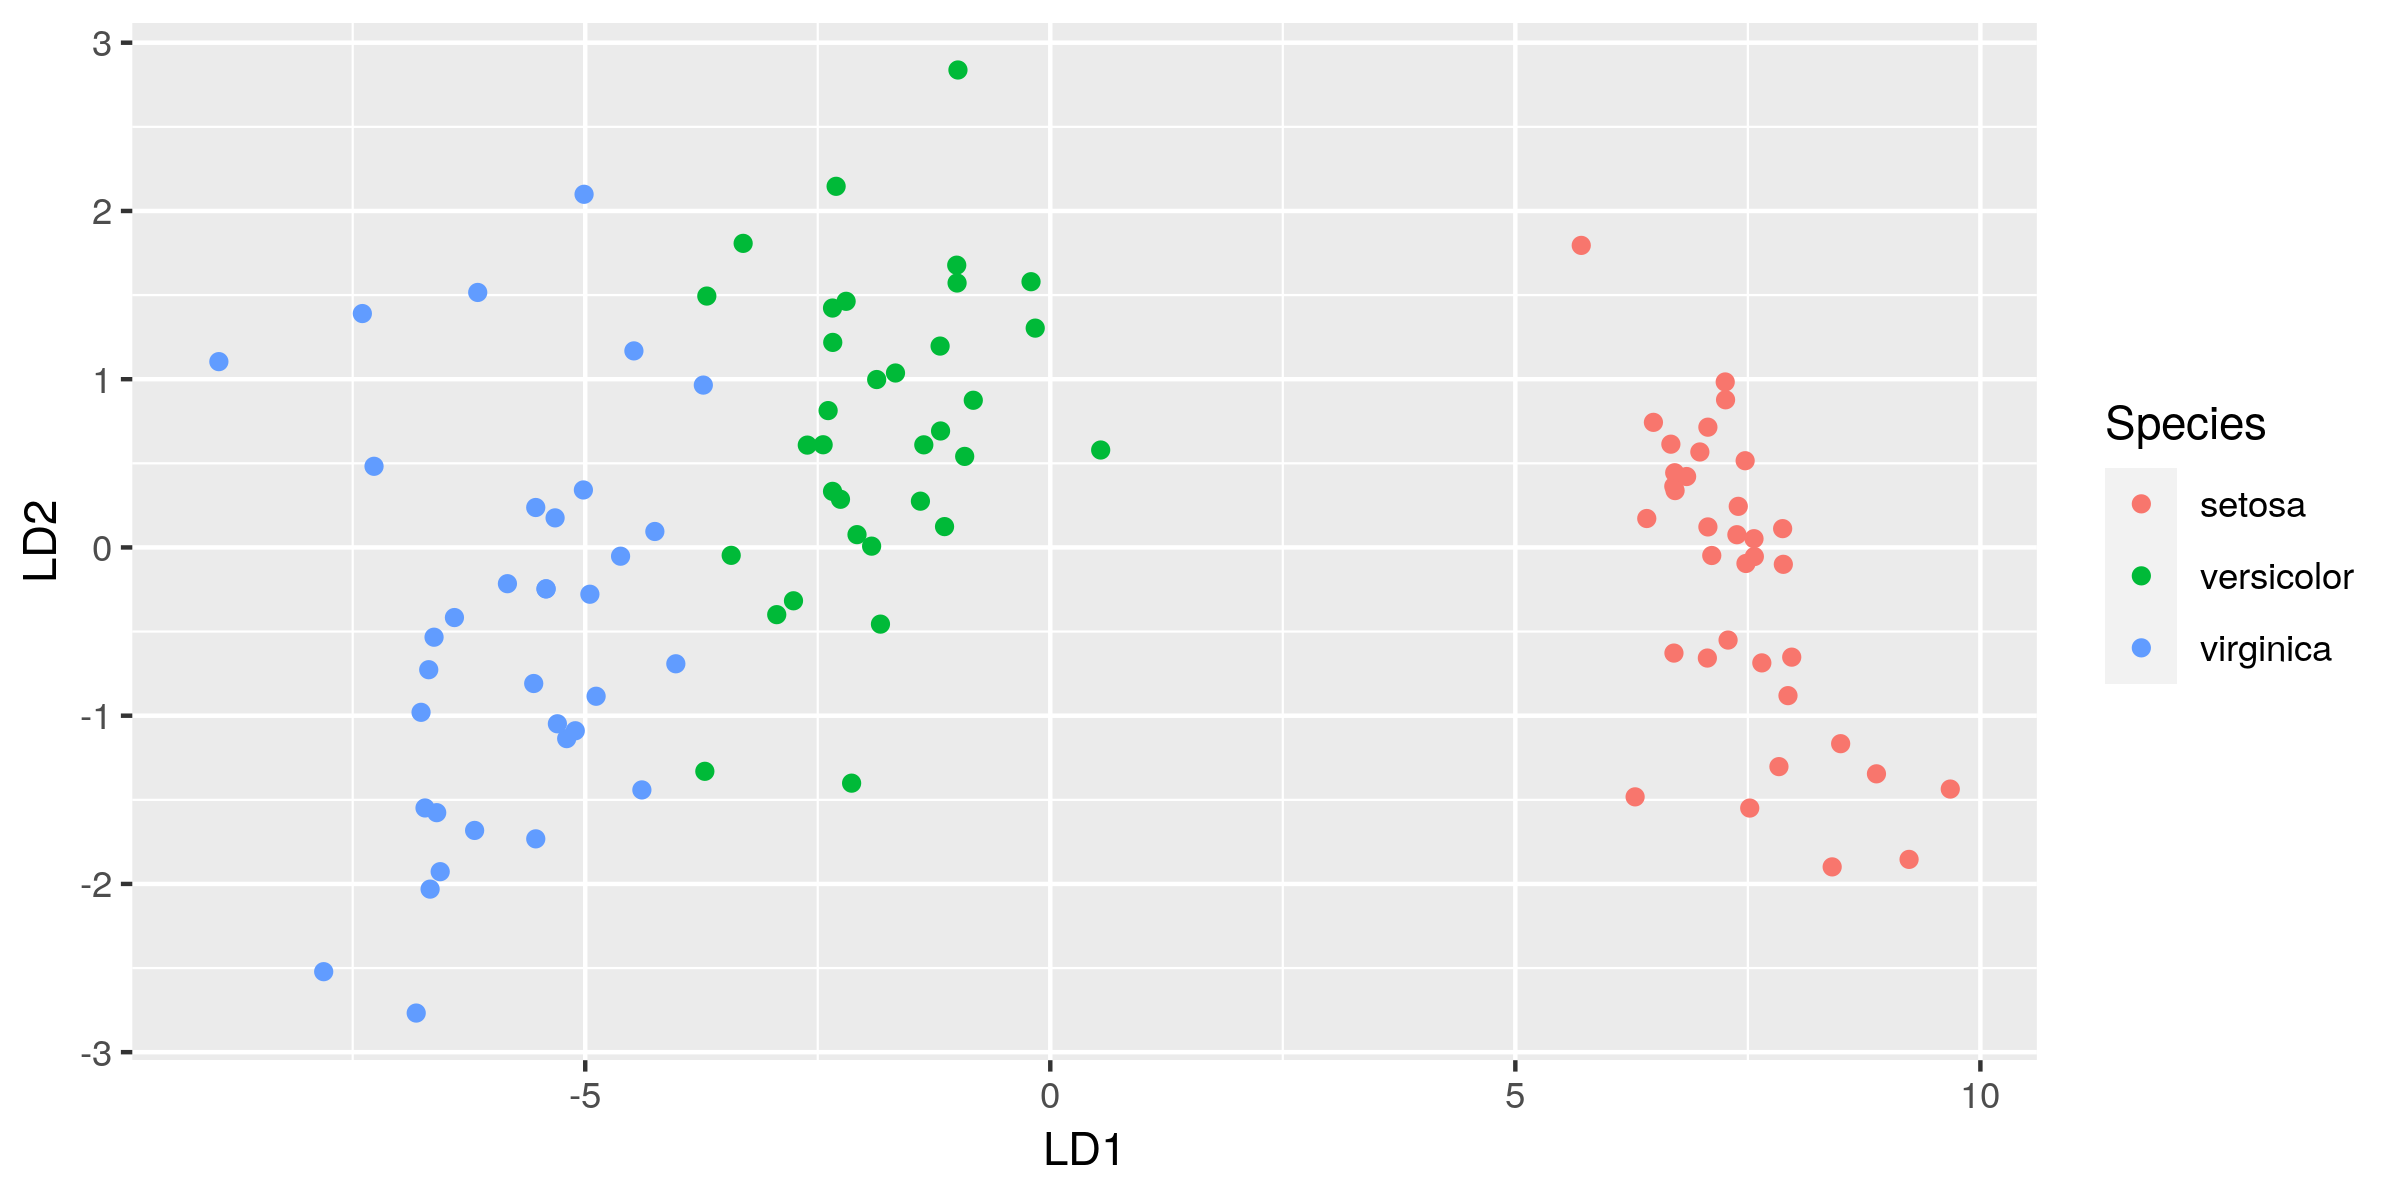

In [47]:
ld_iris<-predict(l,iris_train)
df_ld_iris<-data.frame(ld_iris$x)
df_ld_iris$Species<-iris_train$Species
ggplot(df_ld_iris,aes(x=LD1,y=LD2,color=Species))+geom_point()

In [48]:
pred_test_iris <- predict(l,iris_test)
pred_test_iris

,setosa,versicolor,virginica
1,1.000000e+00,9.294044e-22,1.270903e-41
11,1.000000e+00,3.812748e-23,2.020652e-43
12,1.000000e+00,3.146209e-18,8.657623e-37
16,1.000000e+00,1.146156e-26,5.759668e-47
22,1.000000e+00,3.970640e-20,1.314442e-38
24,1.000000e+00,9.804055e-15,1.779823e-31
26,1.000000e+00,2.264764e-16,7.595265e-35
28,1.000000e+00,3.536967e-21,6.961420e-41
37,1.000000e+00,4.534049e-24,5.703439e-45
38,1.000000e+00,1.081085e-22,5.988742e-43


In [49]:
table(real=iris_test$Species, pred=pred_test_iris$class)

            pred
real         setosa versicolor virginica
  setosa         14          0         0
  versicolor      0         15         1
  virginica       0          0        15

In [50]:
cf_m<-caret::confusionMatrix(data=pred_test_iris$class, reference=iris_test$Species)
cf_m

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         14          0         0
  versicolor      0         15         0
  virginica       0          1        15

Overall Statistics
                                          
               Accuracy : 0.9778          
                 95% CI : (0.8823, 0.9994)
    No Information Rate : 0.3556          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9666          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9375           1.0000
Specificity                 1.0000            1.0000           0.9667
Pos Pred Value              1.0000            1.0000           0.9375
Neg Pred Value              1.0000            0.9667           1.0000
P

https://www.rdocumentation.org/packages/caret/versions/6.0-85/topics/confusionMatrix



In [51]:
paste("La exhaustividad (recall, sensitivity) para Setosa:",cf_m$table[1,1]/sum(cf_m$table[,1]))
paste("La exhaustividad (recall, sensitivity) para Versicolor:",cf_m$table[2,2]/sum(cf_m$table[,2]))
paste("La exhaustividad (recall, sensitivity) para Virginica:",cf_m$table[3,3]/sum(cf_m$table[,3]))

[1] "La exhaustividad (recall, sensitivity) para Setosa: 1"

[1] "La exhaustividad (recall, sensitivity) para Versicolor: 0.9375"

[1] "La exhaustividad (recall, sensitivity) para Virginica: 1"

In [52]:
paste("La precisión (Pos Pred Value) para Setosa:",cf_m$table[1,1]/sum(cf_m$table[1,]))
paste("La precisión (Pos Pred Value) para Versicolor:",cf_m$table[2,2]/sum(cf_m$table[2,]))
paste("La precisión (Pos Pred Value) para Virginica:",cf_m$table[3,3]/sum(cf_m$table[3,]))

[1] "La precisión (Pos Pred Value) para Setosa: 1"

[1] "La precisión (Pos Pred Value) para Versicolor: 1"

[1] "La precisión (Pos Pred Value) para Virginica: 0.9375"

### Comparación con PCA

En PCA también podíamos reducir dimensionalidad, pero al ser agnóstico a la clasificación, no lo hace tan bien cuando tratamos de diferenciar clases etiquetadas a priori:

In [53]:
prmydata<-prcomp(X)
prmydata

Standard deviations (1, .., p=4):
[1] 2.1157711 0.5012835 0.2789981 0.1561995

Rotation (n x k) = (4 x 4):
                     PC1        PC2         PC3        PC4
Sepal.Length  0.37583375  0.6896993  0.54257079  0.2977933
Sepal.Width  -0.07314615  0.6863192 -0.66435805 -0.2867821
Petal.Length  0.85343419 -0.1915156 -0.08587329 -0.4770719
Petal.Width   0.35362228 -0.1288512 -0.50682453  0.7755498

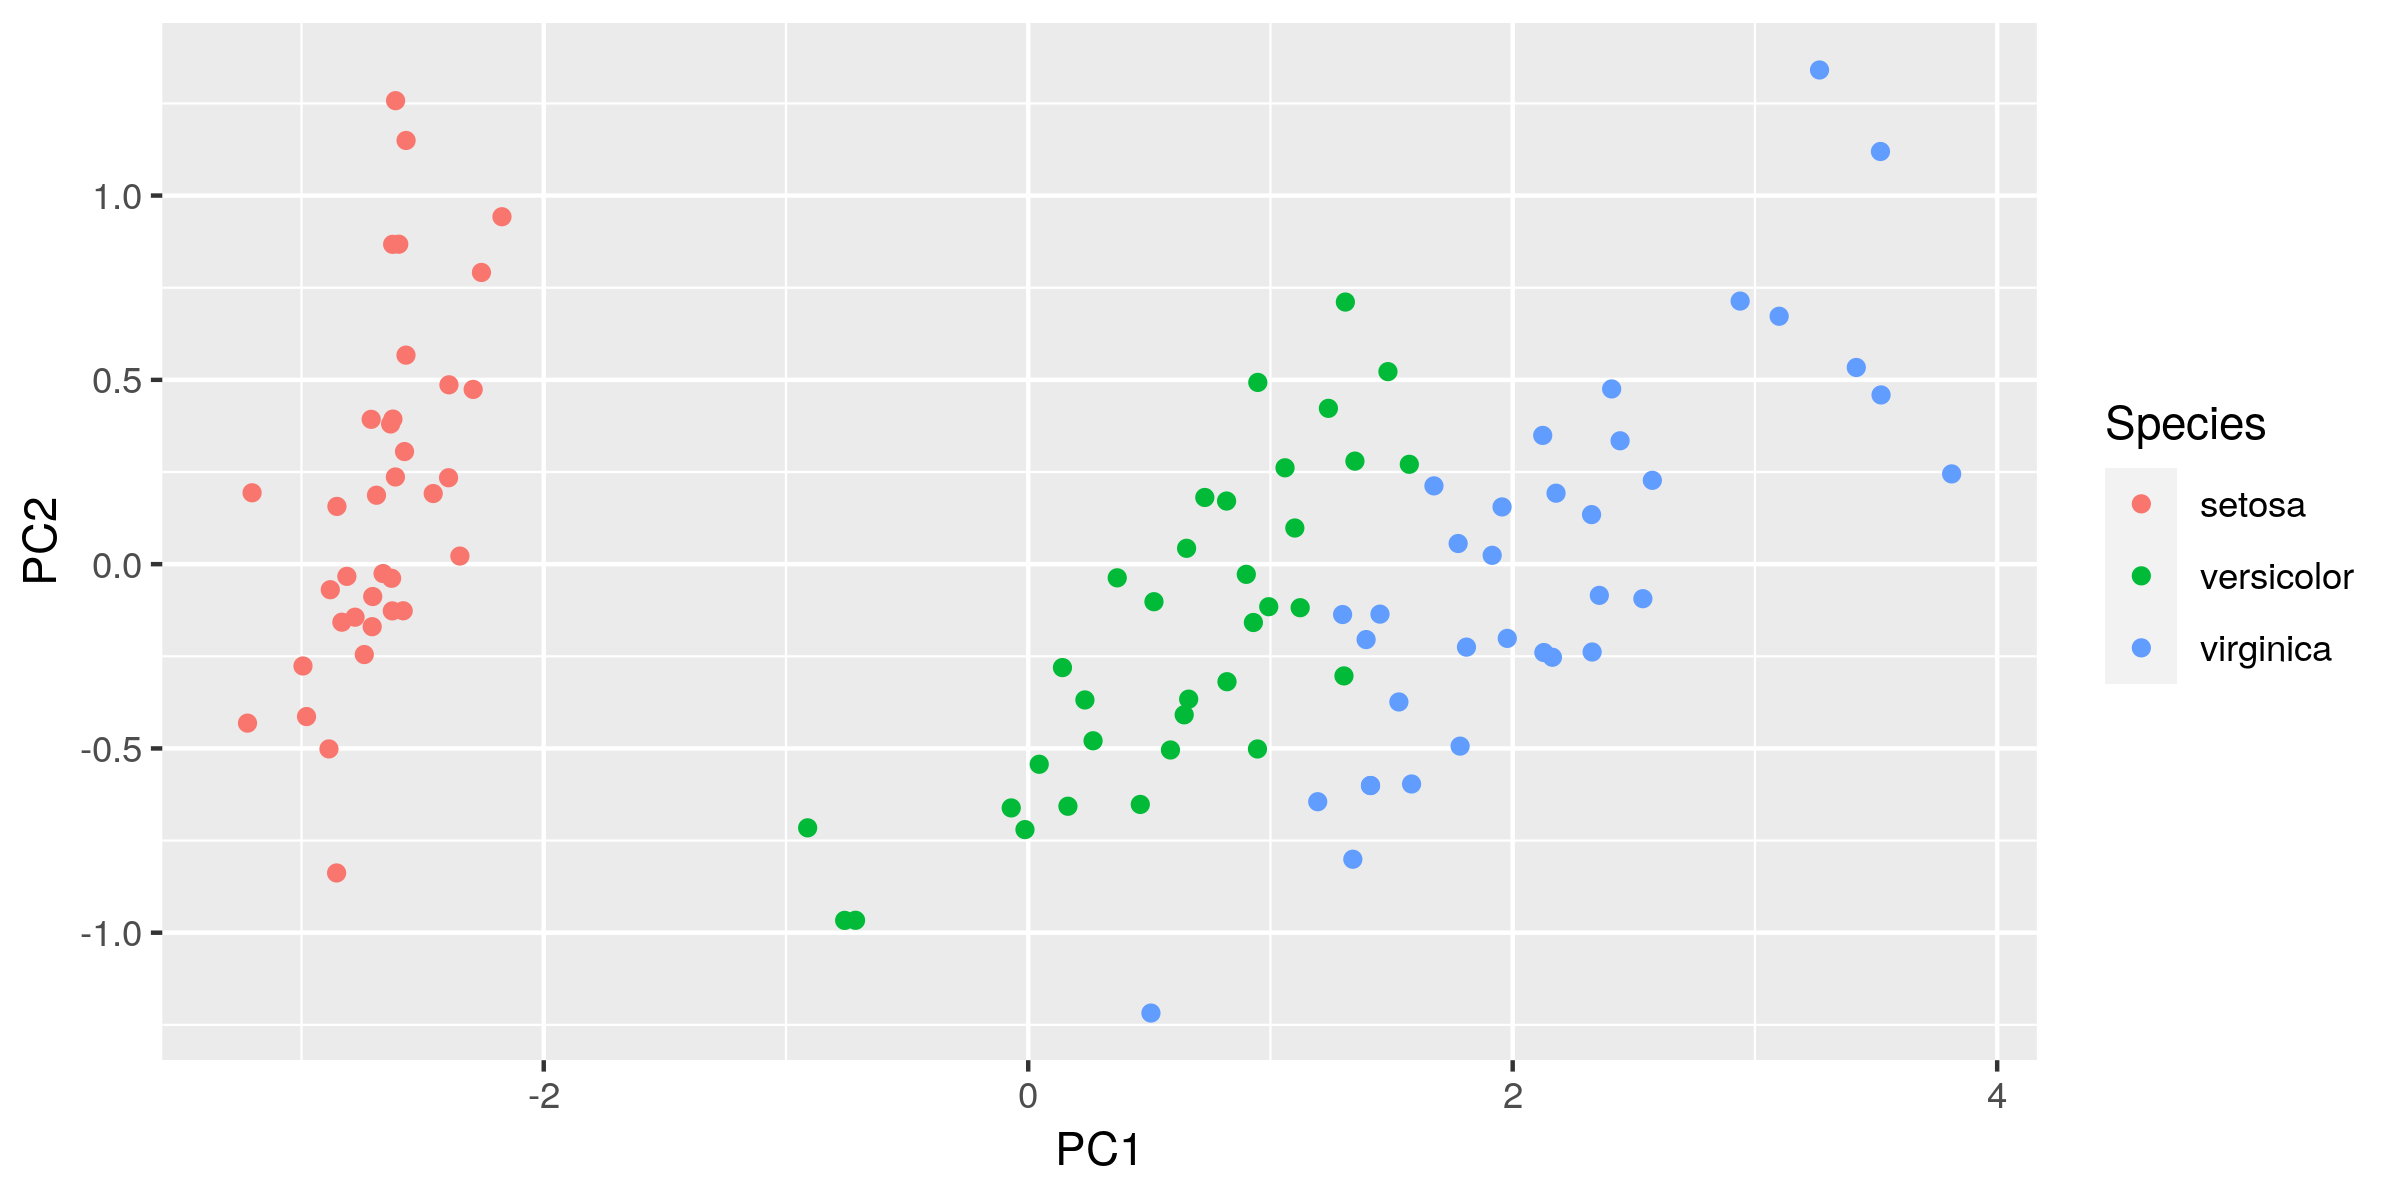

In [54]:
iris_train[,c("PC1","PC2")] <- predict(prmydata,newdata = iris_train[,1:4])[,1:2]

ggplot(iris_train,aes(x=PC1,y=PC2,color=Species))+geom_point()

Información de como repetir este mismo ejercicio en Python:
https://sebastianraschka.com/Articles/2014_python_lda.html#step-5-transforming-the-samples-onto-the-new-subspace